# ASR Dataset Quality Evaluation

Manual quality check of 100 randomly sampled transcriptions from the [dataset](https://huggingface.co/datasets/islomov/news_youtube_uzbek_speech_dataset). 
Evaluated Word Error Rate (WER), Character Error Rate (CER), and foreign language contamination.

**Methodology:**
1. Randomly sampled 100 audio files from the dataset
2. Extracted audio from parquet files using sample IDs
3. Manually verified and corrected transcriptions using custom HTML checker tool
4. Computed WER/CER metrics and foreign words count

In [1]:
import gc  # Garbage collector
import glob
import io
import os

import pandas as pd
import soundfile as sf
from tqdm import tqdm  # Progress bar library

SEED = 137
DATASET_DIR = "../datasets/news_youtube_uzbek_speech_dataset/data"
SAMPLED_AUDIO_DIR = os.path.join(DATASET_DIR, "sampled_audio")
CHUNKED_AUDIO_DIR = os.path.join(DATASET_DIR, "chunked_audio")

ALL_DATA_PATH = os.path.join(DATASET_DIR, "dataset.csv")
SAMPLED_DATA_PATH = os.path.join(DATASET_DIR, "sampled.csv")
PROCESSED_AUDIO_STATS_PATH = os.path.join(DATASET_DIR, "processed_audio_stats.csv")
TRANSCRIPTION_RESULTS_PATH = os.path.join(DATASET_DIR, "google_spt_transcriptions.csv")
VALIDATION_TEST_SETS_PATH = os.path.join(DATASET_DIR, "validation_test_sets.csv")

SAMPLED_DATA2_PATH = os.path.join(DATASET_DIR, "sampled2.csv")
TRANSCRIPTION_RESULTS2_PATH = os.path.join(DATASET_DIR, "google_spt_transcriptions2.csv")

### Create csv file with all data and computed statistics

In [2]:
def compute_statistics(df: pd.DataFrame, ignore_sampling_rate=True) -> dict:
    """Extract statistics without keeping audio in memory"""
    stats = {
        "id": [],
        "text_original": [],
        "path": [],
        "duration": [],
        "char_count": [],
        "word_count": [],
    }
    if not ignore_sampling_rate:
        stats["sampling_rate"] = []

    for i in range(len(df)):
        # Extract metadata
        stats["id"].append(df.iloc[i]["id"])
        stats["path"].append(df.iloc[i]["audio"]["path"])

        text = df.iloc[i]["text"]
        stats["text_original"].append(text)

        # Decode audio
        audio_bytes = df.iloc[i]["audio"]["bytes"]
        audio_array, sr = sf.read(io.BytesIO(audio_bytes))

        duration = len(audio_array) / sr
        stats["duration"].append(duration)
        stats["char_count"].append(len(text))
        stats["word_count"].append(len(text.split()))
        if not ignore_sampling_rate:
            stats["sampling_rate"].append(sr)

        # Clear audio from memory immediately
        del audio_bytes, audio_array

    return stats


parquet_files = glob.glob(f"{DATASET_DIR}/*.parquet")
num_parquets = len(parquet_files)

if num_parquets == 0:
    raise FileNotFoundError(f"No parquet files found. Exiting...")

print(f"Found {num_parquets} parquet files. Started processing...\n")

all_data = []
for parquet_file_path in tqdm(parquet_files, desc="Processing files"):
    df_partial = pd.read_parquet(parquet_file_path)

    stats = compute_statistics(df_partial)
    all_data.append(pd.DataFrame(stats))

    # Explicitly delete the dataframe with heavy audio bytes
    del df_partial
    gc.collect()

# Combine all data
df = pd.concat(all_data, ignore_index=True)
del all_data  # Free memory
gc.collect()

df["id"] = df["id"].astype(int)
df.set_index("id", inplace=True)
df.to_csv(ALL_DATA_PATH)

Found 34 parquet files. Started processing...



Processing files: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


In [10]:
df = pd.read_csv(ALL_DATA_PATH, index_col="id")

print(df.info())
print(df.describe())
print("\nFirst few rows:")
df

<class 'pandas.core.frame.DataFrame'>
Index: 20795 entries, 4285 to 19573
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   text_original  20795 non-null  object 
 1   path           20795 non-null  object 
 2   duration       20795 non-null  float64
 3   char_count     20795 non-null  int64  
 4   word_count     20795 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 974.8+ KB
None
           duration    char_count    word_count
count  20795.000000  20795.000000  20795.000000
mean      25.872685    358.585814     45.937725
std        5.792185    117.732594     15.300639
min        3.013500      8.000000      1.000000
25%       23.877375    291.000000     37.000000
50%       28.709375    378.000000     48.000000
75%       30.000000    443.000000     56.000000
max       30.000062    690.000000     97.000000

First few rows:


,text_original,path,duration,char_count,word_count
id,,,,,
4285,Chiqqandan keyingi rejalarni o'ylab qolganmisi...,00004285.wav,28.518875,425,57
4286,Qoʻchqor Oʻlmas Ismoilovichga Oʻzbekiston Resp...,00004286.wav,25.904000,351,38
4287,Mulki Zulfiya Zayniddinovna nomiga rasmiylasht...,00004287.wav,15.152000,169,19
4288,Oxunov mahalla fuqarolar yig'ini hududida joyl...,00004288.wav,29.509375,331,41
4289,128 million 177 ming 500 soʻm pul hamda 2016-y...,00004289.wav,27.152000,188,28
...,...,...,...,...,...
19569,fikrni bildirdilar va ular mana shu Afgʻon mar...,00019569.wav,30.000000,342,39
19570,Bu angar mana shu xalqaro transport logistik h...,00019570.wav,30.000000,270,34
19571,"Ismatilla Ergashevning maʼlum qilishicha, shu ...",00019571.wav,15.749313,210,23


### Dataset statistics plotted

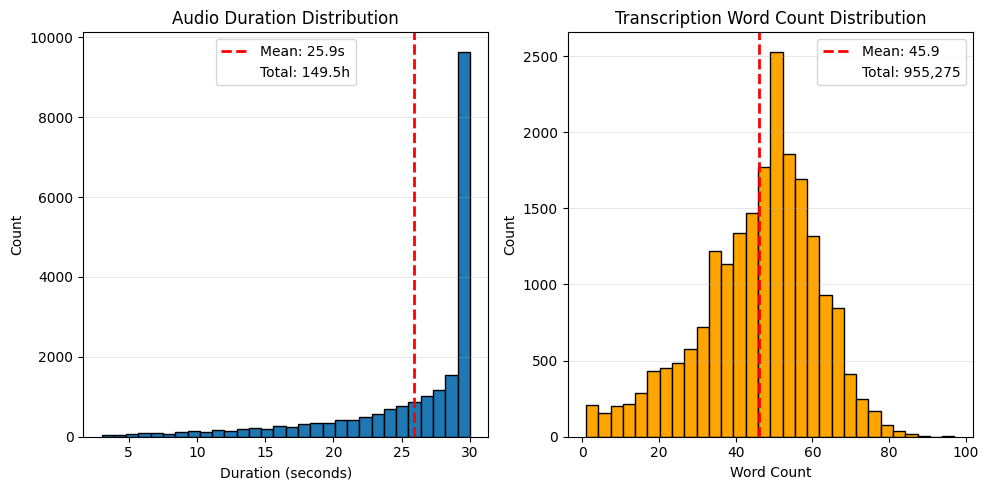

In [12]:
from scripts.dataset_plotting import plot_distribution_graphs

plot_distribution_graphs(df)

### Extract short random samples

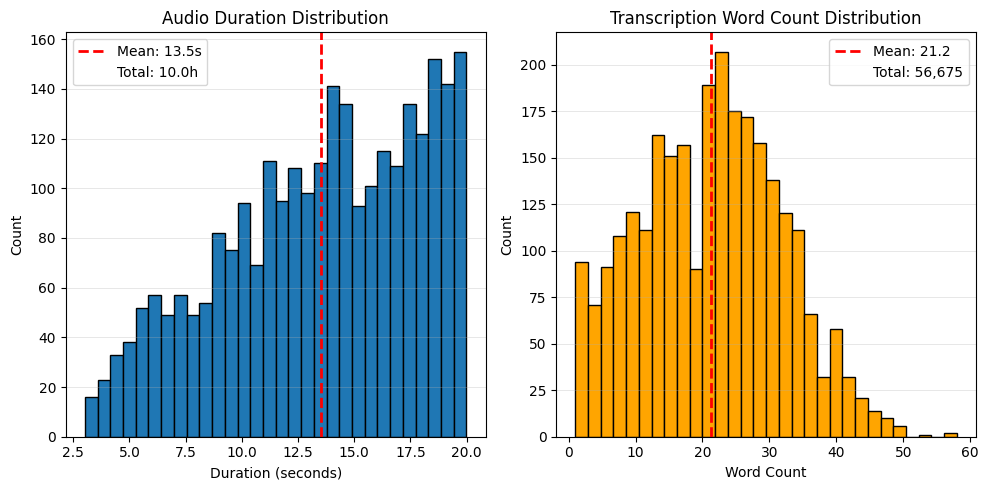

,text_original,path,duration,char_count,word_count
id,,,,,
4,Nimaga? Malayziyada yaxshi universitetlar bor....,00000004.wav,17.285312,273,37
7,ikkita founder bitta kompaniyada ishlagan payt...,00000007.wav,8.464000,98,13
20,va oʻrningizga mutaxassis topilmayapti. Misol ...,00000020.wav,16.442688,282,38
35,"va boshida u kompaniyaga asos solmagan, oddiy ...",00000035.wav,18.512000,324,41
45,"shu narsaga dadam ahamiyat bergan. Bilimni, qa...",00000045.wav,19.130688,334,45
...,...,...,...,...,...
20775,"Yuqori Kengash, Respublika Ministrlar Kengashi...",00020775.wav,15.322688,196,23
20776,"xalq bilan gaplashdi, xalqqa koʻp narsalarni, ...",00020776.wav,7.280000,81,10
20778,"mana havas qilib, e, kelsa boʻlar ekan, Qoraqa...",00020778.wav,17.893375,186,24


In [13]:
medium_audios = (df["duration"] <= 15)
long_audios = (df["duration"] > 15) & (df["duration"] <= 20)

medium_samples = df[medium_audios]
long_random_samples = df[long_audios].sample(1100, random_state=SEED)

sampled_df = pd.concat([medium_samples, long_random_samples]).sort_index()
sampled_df.to_csv(SAMPLED_DATA_PATH, index_label="id")

plot_distribution_graphs(sampled_df)

sampled_df

### Extract audios from parquet files to manually check the quality of the overall dataset

In [143]:
from pathlib import Path
import scripts.audio_preprocessing as ap


def extract_and_normalize_audio_from_parquet(paths_to_extract: set):
    print(f"Need to extract {len(paths_to_extract)} audio files")
    ids_to_filter = set(
        map(lambda path: int(Path(path).stem), paths_to_extract)
    )

    # Create directory for extracted audio
    os.makedirs(SAMPLED_AUDIO_DIR, exist_ok=True)

    parquet_files = glob.glob(f"{DATASET_DIR}/*.parquet")
    num_parquets = len(parquet_files)

    if num_parquets == 0:
        raise FileNotFoundError(f"No parquet files found. Exiting...")

    print(f"Found {num_parquets} parquet files. Started processing...\n")

    stats = []
    found_count = 0
    for parquet_file_path in tqdm(parquet_files, desc="Processing files"):
        if found_count >= len(ids_to_filter):
            break

        df_partial = pd.read_parquet(parquet_file_path)
        df_partial["id"] = df_partial["id"].astype(int)
        df_partial.set_index("id", inplace=True)

        # Filter to only rows we need
        matching_rows = df_partial[df_partial.index.isin(ids_to_filter)]

        if len(matching_rows) < 1:
            del df_partial
            continue

        # Extract and normalize audios from parquet files
        for _, row in matching_rows.iterrows():
            audio_bytes = row["audio"]["bytes"]

            output_filename = row["audio"]["path"]
            output_path = os.path.join(SAMPLED_AUDIO_DIR, output_filename)

            waveform, stat = ap.process_audio_bytes(
                output_filename,
                audio_bytes,
                save_path=output_path,
                normalize=True,
                target_rms_db=-23.0,
                apply_highpass=True,
                highpass_cutoff=80.0,
                remove_silences=True,
                silence_threshold_db=-45.0,
                min_silence_duration=1.3
            )

            stats.append(stat)
            found_count += 1

        # Explicitly delete the dataframe with heavy audio bytes
        del df_partial
        gc.collect()

    print(f"\nExtracted and normalized {found_count} audio files to {SAMPLED_AUDIO_DIR}")
    return pd.DataFrame(stats)

In [6]:
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

paths_to_extract = set(sampled_df["path"])

processed_audio_stats_df = extract_and_normalize_audio_from_parquet(paths_to_extract)
processed_audio_stats_df.to_csv(PROCESSED_AUDIO_STATS_PATH, index=False)

processed_audio_stats_df

Need to extract 2668 audio files
Found 34 parquet files. Started processing...



Processing files: 100%|██████████| 34/34 [02:00<00:00,  3.55s/it]


Extracted and normalized 2668 audio files to ../datasets/news_youtube_uzbek_speech_dataset/data/sampled_audio


,input_audio_filename,original_rms_db,final_rms_db,original_duration,final_duration,reduced_duration,peak_amplitude,is_clipped
0,00004287.wav,-27.4685,-23.1002,15.152000,15.152000,0.0000,0.4516,False
1,00004295.wav,-25.7626,-23.1376,9.968000,9.968000,0.0000,0.5506,False
2,00004296.wav,-27.3637,-23.1122,18.405375,18.405375,0.0000,0.4079,False
3,00004303.wav,-24.0325,-23.1166,12.186687,12.186687,0.0000,0.4591,False
4,00004322.wav,-26.1551,-23.1065,14.629375,14.629375,0.0000,0.5394,False
...,...,...,...,...,...,...,...,...
2663,00019541.wav,-23.1250,-23.1175,5.493500,5.493500,0.0000,0.4816,False
2664,00019555.wav,-24.4751,-23.1585,13.072000,13.072000,0.0000,0.5557,False
2665,00019556.wav,-21.9904,-23.1593,18.821375,17.600000,1.2214,0.5599,False
2666,00019571.wav,-21.0641,-23.1049,15.749313,14.620000,1.1293,0.5790,False


In [7]:
processed_audio_stats_df.describe()

,original_rms_db,final_rms_db,original_duration,final_duration,reduced_duration,peak_amplitude
count,2668.000000,2668.000000,2668.000000,2668.000000,2668.000000,2668.000000
mean,-24.077418,-23.209940,13.519254,13.205623,0.313633,0.600199
std,3.851966,0.094251,4.364499,4.399066,0.923642,0.111716
min,-36.051800,-24.659800,3.013500,2.260000,0.000000,0.223900
25%,-26.892250,-23.243925,10.298687,9.968000,0.000000,0.527200
50%,-24.206950,-23.190400,14.010687,13.696031,0.000000,0.603250
75%,-21.307125,-23.151500,17.306687,16.924516,0.000000,0.674200
max,-12.033000,-23.047900,19.994688,19.994688,12.130000,0.896300


In [14]:
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
processed_audio_stats_df = pd.read_csv(PROCESSED_AUDIO_STATS_PATH)

old_total_duration = sampled_df["duration"].sum() / 3600
old_duration_mean = sampled_df["duration"].mean()

# --- Replace sampled_df.duration using processed_audio_stats_df.final_duration ---

# Merge final_duration into the sampled dataframe
sampled_df = sampled_df.merge(
    processed_audio_stats_df[["input_audio_filename", "final_duration"]],
    how="left",
    left_on="path",
    right_on="input_audio_filename"
)

# Replace duration only where we have final_duration
sampled_df["duration"] = (
    sampled_df["final_duration"].combine_first(sampled_df["duration"])
)

# Drop helper columns
sampled_df = sampled_df.drop(columns=["final_duration"])

# --- Remove suspiciously short and short recordings  ---

# Remove very short audios
mask_short_audio = (processed_audio_stats_df["final_duration"] < 3)
paths_to_remove = processed_audio_stats_df.loc[mask_short_audio, "input_audio_filename"].tolist()

total_reduced_duration = processed_audio_stats_df["reduced_duration"].sum() / 3600

# Remove these rows from processed stats
processed_audio_stats_df = processed_audio_stats_df[
    ~processed_audio_stats_df["input_audio_filename"].isin(paths_to_remove)
]

# Remove these recordings entirely
sampled_df = sampled_df[
    ~sampled_df["path"].isin(paths_to_remove)
]
print(f"{len(paths_to_remove)} recordings are removed from the sample")

# Updated totals
current_total_duration = processed_audio_stats_df["final_duration"].sum() / 3600
current_duration_mean = processed_audio_stats_df["final_duration"].mean()

# Save updated CSVs
processed_audio_stats_df.to_csv(PROCESSED_AUDIO_STATS_PATH)
sampled_df.to_csv(SAMPLED_DATA_PATH, index_label="id")

print(
    f"Before audio preprocessing: total duration - {old_total_duration:,.3f} h | mean {old_duration_mean:,.1f} s"
)
print(
    f"After audio preprocessing: total duration - {current_total_duration:,.3f} h "
    f"(reduced {total_reduced_duration * 60:.0f} min) | mean {current_duration_mean:,.1f} s"
)

sampled_df

0 recordings are removed from the sample
Before audio preprocessing: total duration - 10.019 h | mean 13.5 s
After audio preprocessing: total duration - 9.784 h (reduced 14 min) | mean 13.2 s


,text_original,path,duration,char_count,word_count,input_audio_filename
0,Nimaga? Malayziyada yaxshi universitetlar bor....,00000004.wav,16.380000,273,37,00000004.wav
1,ikkita founder bitta kompaniyada ishlagan payt...,00000007.wav,7.650000,98,13,00000007.wav
2,va oʻrningizga mutaxassis topilmayapti. Misol ...,00000020.wav,16.442688,282,38,00000020.wav
3,"va boshida u kompaniyaga asos solmagan, oddiy ...",00000035.wav,18.512000,324,41,00000035.wav
4,"shu narsaga dadam ahamiyat bergan. Bilimni, qa...",00000045.wav,19.130688,334,45,00000045.wav
...,...,...,...,...,...,...
2663,"Yuqori Kengash, Respublika Ministrlar Kengashi...",00020775.wav,15.322688,196,23,00020775.wav
2664,"xalq bilan gaplashdi, xalqqa koʻp narsalarni, ...",00020776.wav,7.280000,81,10,00020776.wav
2665,"mana havas qilib, e, kelsa boʻlar ekan, Qoraqa...",00020778.wav,17.893375,186,24,00020778.wav
2666,"davomida bir-biriga nima deydi, tarjimon kerak...",00020779.wav,10.930687,97,13,00020779.wav


In [12]:
# Before running set your own PROJECT_ID to .env file (e.g. GOOGLE_CLOUD_PROJECT="your id here")
# from pathlib import Path
from scripts import google_transcribe

# Prepare audio paths
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
audio_paths = sampled_df["path"].apply(lambda file_name: os.path.join(SAMPLED_AUDIO_DIR, file_name)).tolist()

# Process files in parallel using two regions
print(f"Processing {len(audio_paths)} audio files using 2 regions (eu, us)...")
print("Starting parallel transcription...\n")

try:
    results = google_transcribe.transcribe_batch_parallel(
        audio_paths=audio_paths,
        regions=["eu", "us"],
        max_workers=12
    )
except Exception as err:
    print(f"\nCritical error during parallel processing: {type(err).__name__}: {err}")
    raise

# Process results
predicted_transcriptions = []
failed_count = 0
success_count = 0

for result in results:
    transcription_entry = {
        "path": Path(result["path"]).name,
        "predicted_sentence": result["predicted_sentence"],
        "error_message": result["error_message"],
        "error_type": result["error_type"],
    }

    predicted_transcriptions.append(transcription_entry)

    if result["predicted_sentence"] is not None:
        success_count += 1
    else:
        failed_count += 1

# Save results
predicted_transcripts_df = pd.DataFrame(predicted_transcriptions)
predicted_transcripts_df.to_csv(TRANSCRIPTION_RESULTS_PATH, index_label="id")
print(f"\nSaved transcription results to: {TRANSCRIPTION_RESULTS_PATH}")

print(f"\n{'=' * 60}")
print(f"Transcription Complete!")
print(f"{'=' * 60}")
print(f"✓ Successfully transcribed: {success_count}")
print(f"✗ Failed: {failed_count}")
print(f"Success rate: {success_count / len(sampled_df) * 100:.2f}%")

predicted_transcripts_df

Processing 2664 audio files using 2 regions (eu, us)...
Starting parallel transcription...



Transcribing: 100%|██████████| 2664/2664 [14:16<00:00,  3.11file/s]


Saved transcription results to: ../datasets/news_youtube_uzbek_speech_dataset/data/google_spt_transcriptions.csv

Transcription Complete!
✓ Successfully transcribed: 2664
✗ Failed: 0
Success rate: 100.00%


,path,predicted_sentence,error_message,error_type
0,00000064.wav,pulini professor bu 400 dollar pulni cho'ntak ...,None,None
1,00000071.wav,bo'sh turgan,None,None
2,00000007.wav,Ikkita founder bitta kompaniyada ishlagan payt...,None,None
3,00000051.wav,"Hammasi, demak, murakkab bizneslar qilishadi-d...",None,None
4,00000053.wav,"qildim, keyin postdo, keyin associate professo...",None,None
...,...,...,...,...
2659,00020779.wav,"davomida bir-biriga nima deydi, tarjima kerak ...",None,None
2660,00020794.wav,"oshxonali uyi harakatini qil. To'g'ri, to'g'ri.",None,None
2661,00020755.wav,gvardiya xodimlari pichoqlangani va o'lim ro'y...,None,None
2662,00020775.wav,yuqori kengash respublika ministrlar kengashi ...,None,None


In [15]:
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
predicted_transcripts_df = pd.read_csv(TRANSCRIPTION_RESULTS_PATH, index_col="id")

print(predicted_transcripts_df.info())

# Merge transcription results with original data
sampled_df = sampled_df.merge(
    predicted_transcripts_df,
    left_on="path",
    right_on="path",
    how="left"
)
sampled_df

<class 'pandas.core.frame.DataFrame'>
Index: 2664 entries, 0 to 2663
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   path                2664 non-null   object 
 1   predicted_sentence  2576 non-null   object 
 2   error_message       0 non-null      float64
 3   error_type          0 non-null      float64
dtypes: float64(2), object(2)
memory usage: 104.1+ KB
None


,text_original,path,duration,char_count,word_count,input_audio_filename,predicted_sentence,error_message,error_type
0,Nimaga? Malayziyada yaxshi universitetlar bor....,00000004.wav,16.380000,273,37,00000004.wav,Nimaga? Malayziyada yaxshi universitetlar bor....,NaN,NaN
1,ikkita founder bitta kompaniyada ishlagan payt...,00000007.wav,7.650000,98,13,00000007.wav,Ikkita founder bitta kompaniyada ishlagan payt...,NaN,NaN
2,va oʻrningizga mutaxassis topilmayapti. Misol ...,00000020.wav,16.442688,282,38,00000020.wav,va o'rniga mutaxassis topilmayapti. Misol uchu...,NaN,NaN
3,"va boshida u kompaniyaga asos solmagan, oddiy ...",00000035.wav,18.512000,324,41,00000035.wav,"va boshda u kompaniyaga asos solmagan, oddiy s...",NaN,NaN
4,"shu narsaga dadam ahamiyat bergan. Bilimni, qa...",00000045.wav,19.130688,334,45,00000045.wav,"Shu narsaga dadam ahamiyat bergan, bilimni qad...",NaN,NaN
...,...,...,...,...,...,...,...,...,...
2663,"Yuqori Kengash, Respublika Ministrlar Kengashi...",00020775.wav,15.322688,196,23,00020775.wav,yuqori kengash respublika ministrlar kengashi ...,NaN,NaN
2664,"xalq bilan gaplashdi, xalqqa koʻp narsalarni, ...",00020776.wav,7.280000,81,10,00020776.wav,"xalq bilan gaplashdi, xalqqa ko'p tashlandi, k...",NaN,NaN
2665,"mana havas qilib, e, kelsa boʻlar ekan, Qoraqa...",00020778.wav,17.893375,186,24,00020778.wav,"Mana havas qilib kelsa bo'lar ekan-u, Qoraqalp...",NaN,NaN
2666,"davomida bir-biriga nima deydi, tarjimon kerak...",00020779.wav,10.930687,97,13,00020779.wav,"davomida bir-biriga nima deydi, tarjima kerak ...",NaN,NaN


In [16]:
import scripts.similarity_metrics as similarity_metrics

sampled_df.drop(columns=["error_message", "error_type", "input_audio_filename"], inplace=True, errors="ignore")
sampled_df.rename(columns={"predicted_sentence": "text_spt"}, inplace=True)

# Reorder text_original column to be the last column
cols = list(sampled_df.columns)
cols.remove("text_original")
cols.append("text_original")
sampled_df = sampled_df[cols]

# Apply similarity metrics to each row
metrics = sampled_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["text_spt"],  # Google SPT generated text (should be more accurate)
        hypothesis=row["text_original"],  # original Gemini 2.5 Pro generated text
    ),
    axis=1
)

# Convert list of dicts → DataFrame
metrics_df = pd.DataFrame(metrics.tolist())

# Merge metric columns back into main DataFrame and save
sampled_df: pd.DataFrame = pd.concat([sampled_df, metrics_df], axis=1)

sampled_df.sort_values("wer", ascending=False)

,path,duration,char_count,word_count,text_spt,text_original,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
644,00004912.wav,15.781375,283,36,NaN,sizga ruxsatsiz.\nSizga... vo vremya stroitels...,,sizga ruxsatsiz sizga vo vremya stroitelstva y...,36.0,261.0,0.0,0,36
1860,00014869.wav,17.393500,262,34,NaN,"shu mana bu ishni qilibsizlar, zo'r ekan. Tuda...",,shu mana bu ishni qilibsizlar zo'r ekan tuda-s...,34.0,257.0,0.0,0,34
641,00004891.wav,14.778688,229,33,NaN,Man shu paytgacha otvet qilganim yoʻq. Hech qa...,,man shu paytgacha otvet qilganim yo'q hech qay...,33.0,222.0,0.0,0,33
1182,00009349.wav,12.280000,192,30,NaN,"Men srazu otkaz berdim. Ikkita, ikkita postga ...",,men srazu otkaz berdim ikkita ikkita postga be...,32.0,191.0,0.0,0,32
2350,00018501.wav,16.805312,227,32,NaN,million investitsiya. Ulardan bittasi Facebook...,,million investitsiya ulardan bittasi facebook ...,32.0,220.0,0.0,0,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,00009731.wav,4.869375,45,6,"Mana bilasiz, davlat mulkini ijaraga berganda","Mana bilasiz davlat mulkini ijaraga berganda,",mana bilasiz davlat mulkini ijaraga berganda,mana bilasiz davlat mulkini ijaraga berganda,0.0,0.0,1.0,6,6
1230,00009774.wav,4.893500,48,5,"xavflimi, inglizlar qanaqa aldab ketishmaydimi?","xavflimi, inglizlar qanaqa, aldab ketishmaydimi?",xavflimi inglizlar qanaqa aldab ketishmaydimi,xavflimi inglizlar qanaqa aldab ketishmaydimi,0.0,0.0,1.0,5,5
600,00004536.wav,9.893375,125,14,mashg'ulotlar va mashqlar dasturlari tizimli i...,mashg'ulotlar va mashqlar dasturlari tizimli i...,mashg'ulotlar va mashqlar dasturlari tizimli i...,mashg'ulotlar va mashqlar dasturlari tizimli i...,0.0,0.0,1.0,14,14
601,00004540.wav,5.434687,43,4,abituriyentlarga berishlari mumkin o'ziga.,abituriyentlarga berishlari mumkin. Oʻziga.,abituriyentlarga berishlari mumkin o'ziga,abituriyentlarga berishlari mumkin o'ziga,0.0,0.0,1.0,4,4


In [17]:
music_annotation_mask = (sampled_df["text_spt"].isna()) & (sampled_df["hyp_normalized"].isin(["[musiqa]", "(musiqa)"]))

# Update text columns
cols_to_fix = ["text_spt", "ref_normalized", "hyp_normalized"]
sampled_df.loc[music_annotation_mask, cols_to_fix] = "[musiqa]"

# Update the numeric columns
sampled_df.loc[music_annotation_mask, ["wer", "cer"]] = 0.0
sampled_df.loc[music_annotation_mask, ["sequence_similarity"]] = 1.0

sampled_df.describe()

,duration,char_count,word_count,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
count,2668.000000,2668.000000,2668.000000,2668.000000,2668.000000,2668.000000,2668.000000,2668.000000
mean,13.207436,164.282234,21.242504,0.459598,2.214061,0.900595,20.950900,21.630060
std,4.394885,80.050585,10.600035,2.751113,19.265876,0.201709,16.193299,10.802308
min,3.013500,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,9.968000,105.000000,13.000000,0.033300,0.006100,0.918900,13.000000,14.000000
50%,13.696031,166.000000,21.000000,0.105300,0.031750,0.975900,21.000000,22.000000
75%,16.924516,222.000000,29.000000,0.200000,0.077000,0.996300,29.000000,29.000000
max,19.994688,386.000000,58.000000,36.000000,261.000000,1.000000,635.000000,58.000000


In [18]:
# Remove very poor alignment (wer > 20%)
sampled_df = sampled_df[sampled_df["wer"] <= 0.20]
sampled_df.to_csv(SAMPLED_DATA_PATH, index_label="id")

aligned_mask = sampled_df["wer"] == 0.0
len_aligned_recordings = len(sampled_df[aligned_mask])
aligned_duration = sampled_df[aligned_mask]["duration"].sum() / 3600

total_recordings = len(sampled_df)
not_aligned_duration = sampled_df[~aligned_mask]["duration"].sum() / 3600

print(f"Total duration of the sample: {sampled_df["duration"].sum() / 3600:.2f} hours")
print(
    f"Audio and transcription aligned recordings: {len_aligned_recordings:,} - {aligned_duration:.2f} hours")
print(
    f"Remaining recordings: {total_recordings - len_aligned_recordings:,} - {not_aligned_duration:.2f} hours")
sampled_df.describe()

Total duration of the sample: 7.55 hours
Audio and transcription aligned recordings: 600 - 1.85 hours
Remaining recordings: 1,420 - 5.71 hours


,duration,char_count,word_count,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
count,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000,2020.000000
mean,13.463748,168.277228,21.649010,0.074965,0.028957,0.944222,21.779703,22.073267
std,4.291046,79.307668,10.483416,0.064066,0.035599,0.143476,10.650580,10.696478
min,3.088687,8.000000,1.000000,0.000000,0.000000,0.007400,0.000000,1.000000
25%,10.370703,112.000000,14.000000,0.000000,0.000000,0.963175,14.000000,14.000000
50%,13.936000,170.000000,22.000000,0.071400,0.018000,0.987350,22.000000,22.000000
75%,17.095984,226.250000,29.000000,0.125000,0.044300,1.000000,30.000000,30.000000
max,19.994688,370.000000,54.000000,0.200000,0.382400,1.000000,53.000000,54.000000


In [49]:
import glob

sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

all_audio_paths = set(glob.glob(os.path.join(SAMPLED_AUDIO_DIR, "*.wav")))
audio_paths_to_keep = set(
    sampled_df["path"]
    .apply(lambda file_name: os.path.join(SAMPLED_AUDIO_DIR, file_name))
)
audio_paths_to_remove = all_audio_paths - audio_paths_to_keep

for path in audio_paths_to_remove:
    os.remove(path)

print(f"Removed unnecessary {len(audio_paths_to_remove):,} audio files")

Removed unnecessary 665 audio files


In [44]:
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

interested_cols = ["path", "text_spt", "text_original", "ref_normalized", "hyp_normalized", "wer",
                   "sequence_similarity", "duration"]
misaligned_df = sampled_df[sampled_df["wer"] > 0]
random_sample = misaligned_df.sample(200, random_state=SEED)

# Get the Top WER Sample (excluding the random ones)
top_wer_sample = misaligned_df.drop(random_sample.index).nlargest(150, "wer")

to_manually_check_df = pd.concat([random_sample, top_wer_sample])[interested_cols]
to_manually_check_df.to_csv(os.path.join(DATASET_DIR, "check_alignment_manually.csv"), index_label="id")
print(f"Total duration to be manually checked: {to_manually_check_df["duration"].sum() / 3600:.2f} hours")
to_manually_check_df

Total duration to be manually checked: 1.38 hours


,path,text_spt,text_original,ref_normalized,hyp_normalized,wer,sequence_similarity,duration
id,,,,,,,,
942,00007611.wav,"xalq dushmaniga ham chiqarib yuborardida, ya'n...","xalq dushmaniga ham chiqarib yuborar edi-da, y...",xalq dushmaniga ham chiqarib yuborardida ya'ni...,xalq dushmaniga ham chiqarib yuborar edi-da ya...,0.1481,0.9760,12.538687
250,00001766.wav,Sherali Jo'rayev nomini qoralamaslikni iltimos...,Sherali Jo'rayev nomini qoralamasligini iltimo...,sherali jo'rayev nomini qoralamaslikni iltimos...,sherali jo'rayev nomini qoralamasligini iltimo...,0.0882,0.3901,17.061375
653,00005015.wav,so'ng albatta yana ko'rishamiz va ma'lum bir s...,undan soʻng albatta yana koʻrishamiz va maʼlum...,so'ng albatta yana ko'rishamiz va ma'lum bir s...,undan so'ng albatta yana ko'rishamiz va ma'lum...,0.0833,0.9799,17.593500
1387,00010899.wav,Mana shu 10-15 000 dollar hattoki 20 000 dolla...,mana shu 10 15 000 dollar hatto 20 000 dollarg...,mana shu o'n-o'n besh ming dollar hattoki yigi...,mana shu o'n o'n besh ming dollar hatto yigirm...,0.1111,0.8997,18.586688
1678,00013064.wav,Shu nuqtai nazardan biz mana shu nam havo oqim...,shu nuqtai nazardan biz mana shu nam havo oqim...,shu nuqtai nazardan biz mana shu nam havo oqim...,shu nuqtai nazardan biz mana shu nam havo oqim...,0.0385,0.9842,14.458687
...,...,...,...,...,...,...,...,...
1993,00015748.wav,99% o'zbeklarga shu narsa taalluqli bo'lsa ker...,bir 99% o'zbeklarga shu narsa taalluqli bo'lsa...,to'qson to'qqiz foiz o'zbeklarga shu narsa taa...,bir to'qson to'qqiz foiz o'zbeklarga shu narsa...,0.1739,0.9560,12.218687
162,00001147.wav,Qanaqadir bir oluvchi sotuvchidan yaxshiroq bi...,"qanaqadir bir, e, oluvchi, sotuvchidan yaxshir...",qanaqadir bir oluvchi sotuvchidan yaxshiroq bi...,qanaqadir bir e oluvchi sotuvchidan yaxshiroq ...,0.1724,0.4557,17.658687
843,00006758.wav,va Doktor Maks sirop dor vositasini davlat ro'...,va Doktor Maks sirop dori vositasini davlat ro...,va doktor maks sirop dor vositasini davlat ro'...,va doktor maks sirop dori vositasini davlat ro...,0.1724,0.2618,16.773375


In [19]:
# from scripts import similarity_metrics

checked_df = pd.read_csv(os.path.join(DATASET_DIR, "news_dataset_checked.csv"), index_col="id")
checked_df = checked_df[~checked_df["sentence_checked"].isna()]

google_spt_metrics = checked_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["sentence_checked"],
        hypothesis=row["text_spt"],  # Google SPT generated text
    ),
    axis=1
)
google_spt_metrics = pd.DataFrame(google_spt_metrics.tolist(), checked_df.index)

gemini_metrics = checked_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["sentence_checked"],
        hypothesis=row["text_original"],  # Gemini 2.5 Pro generated text
    ),
    axis=1
)
gemini_metrics = pd.DataFrame(gemini_metrics.tolist(), checked_df.index)

print(f"Manually checked total duration: {checked_df["duration"].sum() / 3600:.2f} hours")
print(f"Original WER - Google SPT to Gemini 2.5 Pro: {checked_df["wer"].mean() * 100:.2f}%")
print(f"Estimated WER of Google SPT: {google_spt_metrics["wer"].mean() * 100:.2f}%")
print(f"Estimated WER of Gemini 2.5 Pro: {gemini_metrics["wer"].mean() * 100:.2f}%")

google_spt_metrics.sort_values("wer", ascending=False)

Manually checked total duration: 1.33 hours
Original WER - Google SPT to Gemini 2.5 Pro: 14.15%
Estimated WER of Google SPT: 8.34%
Estimated WER of Gemini 2.5 Pro: 9.31%


,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
id,,,,,,,
291,mumkinligi to'g'risida yurtdoshlarimizga aytib...,mumkinligi to'g'risida yurtdoshlarimizga yetka...,0.4000,0.1667,0.8871,5,5
2160,o'z ustingizda ishlashni davom ettiring qalamp...,ishlashni davom ettiring qalampirda qoling,0.2857,0.2632,0.8485,7,5
132,va buni odam individual ravishda o'zi o'rganis...,va buni odam individual ravishda o'zi o'rganis...,0.2857,0.1789,0.8940,28,23
1405,va ayting shtobi kirib o'sha tam je medsyostr ...,i think shtobi kirib o'sha tam je med sestra s...,0.2800,0.0932,0.9371,25,26
948,mani pulim riskda bo'lmaydimi deydi hozir mana...,pulim riskda bo'lmaydimi deydi hozir mana o'zb...,0.2727,0.1250,0.9272,11,10
...,...,...,...,...,...,...,...
1678,shu nuqtai nazardan biz mana shu nam havo oqim...,shu nuqtai nazardan biz mana shu nam havo oqim...,0.0000,0.0000,1.0000,26,26
1387,mana shu o'n-o'n besh ming dollar hattoki yigi...,mana shu o'n-o'n besh ming dollar hattoki yigi...,0.0000,0.0000,1.0000,36,36
653,so'ng albatta yana ko'rishamiz va ma'lum bir s...,so'ng albatta yana ko'rishamiz va ma'lum bir s...,0.0000,0.0000,1.0000,24,24


In [20]:
from sklearn.model_selection import train_test_split

checked_df.drop(columns=["text_spt", "ref_normalized", "hyp_normalized", "wer", "sequence_similarity"],
                inplace=True)
checked_df.rename(columns={"sentence_checked": "text_spt"}, inplace=True)

# Merge Google Gemini results
checked_df = pd.concat([checked_df, gemini_metrics], axis=1)

# Split manually checked dataset into validation and test sets
val_df, test_df = train_test_split(checked_df, test_size=0.6, random_state=SEED)

# Label the subsets
val_df = val_df.assign(type="validation")
test_df = test_df.assign(type="test")

# Merge back into the original variable name
checked_df = pd.concat([val_df, test_df])

# Reorder columns
cols = list(checked_df.columns)
cols.remove("text_original")
cols.remove("type")
cols.insert(3, "text_original")
cols.insert(2, "type")
checked_df = checked_df[cols]

print(f"Validation set duration: {val_df["duration"].sum() / 60:.0f} minutes")
print(f"Test set duration: {test_df["duration"].sum() / 60:.0f} minutes")

checked_df.to_csv(VALIDATION_TEST_SETS_PATH, index_label="id")
checked_df

Validation set duration: 32 minutes
Test set duration: 48 minutes


,path,duration,type,text_spt,text_original,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
id,,,,,,,,,,,,
933,00007561.wav,12.730688,validation,Velik haydamagan hozir qizingiz bitta ikki bal...,Velik haydamagan hozir qizingiz bitta ikki bal...,velik haydamagan hozir qizingiz bitta ikki bal...,velik haydamagan hozir qizingiz bitta ikki bal...,0.2000,0.0616,0.5534,30,29
2470,00019509.wav,8.485375,validation,Nega ular O'zbekistonda bemalol ishlab yurishi...,shiradi. Nega ular O'zbekistonda bemalol ishla...,nega ular o'zbekistonda bemalol ishlab yurishibdi,shiradi nega ular o'zbekistonda bemalol ishlab...,0.1667,0.1633,0.9245,6,7
653,00005015.wav,17.593500,validation,so'ng albatta yana ko'rishamiz va ma'lum bir s...,undan soʻng albatta yana koʻrishamiz va maʼlum...,so'ng albatta yana ko'rishamiz va ma'lum bir s...,undan so'ng albatta yana ko'rishamiz va ma'lum...,0.0833,0.0410,0.9799,24,25
1899,00015180.wav,18.042687,validation,"Yozgan odam bu ertangi kunim bolamni, mani O'z...","yozgan odam, u ertangi kunim, bolamni, mana O'...",yozgan odam bu ertangi kunim bolamni mani o'zb...,yozgan odam u ertangi kunim bolamni mana o'zbe...,0.1143,0.0207,0.7329,35,35
2091,00016615.wav,15.301375,validation,"Londonda yashab kelayotgan. Bahriddin, siz man...","Londonda yashab kelayotgan. Bahriddin, siz man...",londonda yashab kelayotgan bahriddin siz mana ...,londonda yashab kelayotgan bahriddin siz mana ...,0.1579,0.0381,0.7784,38,38
...,...,...,...,...,...,...,...,...,...,...,...,...
2464,00019457.wav,19.898688,test,mashina chiqadi. O'zini avtomobil sanoati bor....,tasida mashina chiqadi. O'zini avtomobil sanoa...,mashina chiqadi o'zini avtomobil sanoati bor o...,tasida mashina chiqadi o'zini avtomobil sanoat...,0.0682,0.0357,0.9792,44,46
1339,00010456.wav,19.429375,test,o'sha paytda ko'mib tashlashganda beton tushsa...,o'sha paytda ko'mib tashlashganda beton qilsa....,o'sha paytda ko'mib tashlashganda beton tushsa...,o'sha paytda ko'mib tashlashganda beton qilsa ...,0.0976,0.0674,0.2149,41,43
2567,00020183.wav,18.192000,test,Hamma baravariga remont qilgandan keyin birov ...,"hamma baravariga remont qilgandan keyin, birov...",hamma baravariga remont qilgandan keyin birov ...,hamma baravariga remont qilgandan keyin birov ...,0.0312,0.0042,0.9979,32,32


In [21]:
sampled_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
val_test_df = pd.read_csv(VALIDATION_TEST_SETS_PATH, index_col="id")

# Remove samples that already belong to validation or test sets
sampled_df = sampled_df[~sampled_df["path"].isin(val_test_df["path"])]
sampled_df["type"] = "train"

sampled_df = pd.concat([sampled_df, val_test_df])

# Reorder columns
cols = list(sampled_df.columns)
cols.remove("type")
cols.insert(2, "type")
sampled_df = sampled_df[cols]

sampled_df.to_csv(SAMPLED_DATA_PATH, index_label="id")
sampled_df.describe()

,duration,char_count,word_count,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
count,2021.000000,1681.00000,1681.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000
mean,13.466848,164.41047,21.114813,0.067160,0.025432,0.949262,21.837704,22.083622
std,4.292247,80.01146,10.562085,0.060431,0.032417,0.138016,10.665777,10.703957
min,3.088687,8.00000,1.000000,0.000000,0.000000,0.007400,0.000000,1.000000
25%,10.373375,107.00000,14.000000,0.000000,0.000000,0.967600,14.000000,14.000000
50%,13.936000,167.00000,21.000000,0.062500,0.015900,0.989200,22.000000,22.000000
75%,17.104000,223.00000,28.000000,0.117600,0.039000,1.000000,30.000000,30.000000
max,19.994688,370.00000,54.000000,0.303000,0.382400,1.000000,53.000000,54.000000


In [22]:
print(f"Total sampled duration: {sampled_df["duration"].sum() / 3600:.2f}h")
(sampled_df.groupby("type")["duration"].sum() / 3600).sort_values(ascending=False)

Total sampled duration: 7.56h


type
train         6.227458
test          0.800866
validation    0.531814
Name: duration, dtype: float64

## Part 2

In [42]:
all_data_df = pd.read_csv(ALL_DATA_PATH, index_col="id")
used_paths = set(pd.read_csv(PROCESSED_AUDIO_STATS_PATH)["input_audio_filename"])
unused_data_df = all_data_df[~all_data_df["path"].isin(used_paths)]
print(f"Total available duration: {unused_data_df["duration"].sum() / 3600:.2f} hours")
unused_data_df.describe(include="all")

Total available duration: 139.44 hours


,text_original,path,duration,char_count,word_count
count,18131,18131,18131.000000,18131.000000,18131.000000
unique,18095,18131,NaN,NaN,NaN
top,[musiqa],00004285.wav,NaN,NaN,NaN
freq,17,1,NaN,NaN,NaN
mean,NaN,NaN,27.685610,387.102366,49.562021
std,NaN,NaN,3.168786,92.799635,12.227831
min,NaN,NaN,3.376000,8.000000,1.000000
25%,NaN,NaN,26.181344,328.000000,42.000000
50%,NaN,NaN,29.328000,395.000000,50.000000
75%,NaN,NaN,30.000000,452.000000,58.000000


In [5]:
# import scripts.audio_preprocessing as ap

# Extract audios from parquet files.
unused_ids = set(unused_data_df.index.tolist())
print(f"Need to extract {len(unused_ids)} audio files")

# Create directory for extracted audio
os.makedirs(SAMPLED_AUDIO_DIR, exist_ok=True)

parquet_files = glob.glob(f"{DATASET_DIR}/*.parquet")
num_parquets = len(parquet_files)

if num_parquets == 0:
    raise FileNotFoundError(f"No parquet files found. Exiting...")

print(f"Found {num_parquets} parquet files. Started processing...\n")

stats = []
found_count = 0
for parquet_file_path in tqdm(parquet_files, desc="Processing files"):
    if found_count >= len(unused_ids):
        break

    df_partial = pd.read_parquet(parquet_file_path)
    df_partial["id"] = df_partial["id"].astype(int)
    df_partial.set_index("id", inplace=True)

    # Filter to only rows we need
    matching_rows = df_partial[df_partial.index.isin(unused_ids)]

    if len(matching_rows) < 1:
        del df_partial
        continue

    # Extract and normalize audios from parquet files
    audio_stats_partial_df = pd.DataFrame()
    for _, row in matching_rows.iterrows():
        audio_bytes = row["audio"]["bytes"]

        output_filename = row["audio"]["path"]
        output_path = os.path.join(SAMPLED_AUDIO_DIR, output_filename)

        waveform, stat = ap.process_audio_bytes(
            output_filename,
            audio_bytes,
            save_path=output_path,
            normalize=True,
            target_rms_db=-23.0,
            apply_highpass=True,
            highpass_cutoff=80.0,
            remove_silences=True,
            silence_threshold_db=-45.0,
            min_silence_duration=2.3  # Increase it for this case (more natural chunking later)
        )

        stats.append(stat)
        found_count += 1

    # Explicitly delete the dataframe with heavy audio bytes
    del df_partial
    gc.collect()

processed_audio_stats_df = pd.DataFrame(stats)
processed_audio_stats_df.to_csv(PROCESSED_AUDIO_STATS_PATH.replace(".csv", "_2.csv"), index=False)

print(f"\nExtracted and normalized {found_count} audio files to {SAMPLED_AUDIO_DIR}")
processed_audio_stats_df

Need to extract 18131 audio files
Found 34 parquet files. Started processing...



Processing files: 100%|██████████| 34/34 [14:19<00:00, 25.29s/it]


Extracted and normalized 18131 audio files to ../datasets/news_youtube_uzbek_speech_dataset/data/sampled_audio


,input_audio_filename,original_rms_db,final_rms_db,original_duration,final_duration,reduced_duration,peak_amplitude,is_clipped
0,00004285.wav,-23.0256,-23.0930,28.518875,28.518875,0.0,0.4685,False
1,00004286.wav,-26.1612,-23.0886,25.904000,25.904000,0.0,0.4781,False
2,00004288.wav,-27.1001,-23.1108,29.509375,29.509375,0.0,0.4581,False
3,00004289.wav,-23.5646,-23.1069,27.152000,27.152000,0.0,0.4645,False
4,00004290.wav,-25.7690,-23.1059,25.360000,25.360000,0.0,0.4968,False
...,...,...,...,...,...,...,...,...
18126,00019567.wav,-20.9066,-23.1510,30.000000,30.000000,0.0,0.6385,False
18127,00019568.wav,-21.5962,-23.1500,30.000000,30.000000,0.0,0.5257,False
18128,00019569.wav,-24.7419,-23.1740,30.000000,30.000000,0.0,0.6400,False
18129,00019570.wav,-23.5285,-23.1569,30.000000,30.000000,0.0,0.5755,False


In [3]:
from scripts.audio_preprocessing import chunk_audio_on_silence
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial

os.makedirs(CHUNKED_AUDIO_DIR, exist_ok=True)

unused_paths = list(unused_data_df["path"])

# Create partial function with fixed arguments
process_fn = partial(
    chunk_audio_on_silence,
    input_dir=SAMPLED_AUDIO_DIR,
    output_dir=CHUNKED_AUDIO_DIR,
    min_silence_len=500,
    silence_thresh=-45,
    keep_silence=250,
    min_chunk_ms=4000,
    max_chunk_ms=15000,
)

metadata = []

with ProcessPoolExecutor(max_workers=8) as executor:
    futures = {executor.submit(process_fn, f): f for f in unused_paths}

    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing files"):
        try:
            metadata.extend(future.result())
        except Exception as e:
            print(f"Error processing {futures[future]}: {e}")

chunked_df = pd.DataFrame(metadata)
chunked_df.to_csv(os.path.join(DATASET_DIR, "chunked_data.csv"), index=False)
print(f"Average duration: {chunked_df['duration_sec'].mean():.2f}s")
chunked_df

Processing files: 100%|██████████| 18131/18131 [10:34<00:00, 28.56it/s]

Average duration: 15.50s


,path,chunk_path,duration_sec,chunk_index
0,00004290.wav,00004290_0.wav,22.52,0
1,00004293.wav,00004293_0.wav,18.68,0
2,00004289.wav,00004289_0.wav,10.67,0
3,00004289.wav,00004289_1.wav,14.26,1
4,00004288.wav,00004288_0.wav,27.08,0
...,...,...,...,...
29386,00019568.wav,00019568_0.wav,28.47,0
29387,00019567.wav,00019567_0.wav,28.46,0
29388,00019569.wav,00019569_0.wav,28.24,0
29389,00019570.wav,00019570_0.wav,28.47,0


In [43]:
chunked_df = pd.read_csv(os.path.join(DATASET_DIR, "chunked_data.csv"))

medium_audios = (chunked_df["duration"] >= 3) & (chunked_df["duration"] <= 15)
long_audios = (chunked_df["duration"] > 15) & (chunked_df["duration"] <= 30)

medium_samples = chunked_df[medium_audios]
long_random_samples = chunked_df[long_audios]

sampled2_df = pd.concat([medium_samples, long_random_samples]).sort_index()
sampled2_df.to_csv(SAMPLED_DATA2_PATH, index_label="id")

print(f"Average duration: {sampled2_df["duration"].mean():.2f} seconds")
print(f"Total duration: {sampled2_df["duration"].sum() / 3600:.2f} hours")
sampled2_df

Average duration: 15.50 seconds
Total duration: 126.52 hours


,path,chunk_path,duration,chunk_index
0,00004290.wav,00004290_0.wav,22.52,0
1,00004293.wav,00004293_0.wav,18.68,0
2,00004289.wav,00004289_0.wav,10.67,0
3,00004289.wav,00004289_1.wav,14.26,1
4,00004288.wav,00004288_0.wav,27.08,0
...,...,...,...,...
29386,00019568.wav,00019568_0.wav,28.47,0
29387,00019567.wav,00019567_0.wav,28.46,0
29388,00019569.wav,00019569_0.wav,28.24,0
29389,00019570.wav,00019570_0.wav,28.47,0


In [2]:
# Before running set your own PROJECT_ID to .env file (e.g. GOOGLE_CLOUD_PROJECT="your id here")
# from pathlib import Path
from scripts import google_transcribe

# Configuration
CHECKPOINT_INTERVAL = 1000  # Save every 1000 audio files
CHECKPOINT_PATH = "transcription_checkpoint.csv"

sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

# Prepare audio paths
audio_paths = sampled2_df["chunk_path"].apply(
    lambda file_name: os.path.join(CHUNKED_AUDIO_DIR, file_name)
).tolist()

# Check for existing checkpoint
existing_results = []
processed_paths = set()

if os.path.exists(CHECKPOINT_PATH):
    print(f"Found existing checkpoint: {CHECKPOINT_PATH}")
    checkpoint_df = pd.read_csv(CHECKPOINT_PATH)
    existing_results = checkpoint_df.to_dict('records')
    processed_paths = set(checkpoint_df["path"].apply(lambda x: Path(x).name))
    print(f"Resuming from checkpoint with {len(existing_results)} already processed files")

    # Filter out already processed files
    audio_paths = [
        path for path in audio_paths
        if Path(path).name not in processed_paths
    ]
    print(f"Remaining files to process: {len(audio_paths)}")

# Process files in parallel using two regions
print(f"\nProcessing {len(audio_paths)} audio files using 2 regions (eu, us)...")
print("Starting parallel transcription with checkpoint saving...\n")


def save_checkpoint(results_list, is_final=False):
    """Save current results to checkpoint file"""
    df = pd.DataFrame(results_list)
    df.to_csv(CHECKPOINT_PATH, index_label="id")
    status = "FINAL" if is_final else "CHECKPOINT"
    print(f"\n[{status}] Saved {len(results_list)} results to: {CHECKPOINT_PATH}")


try:
    # Start with existing results
    all_results = existing_results.copy()

    # Process remaining files
    if audio_paths:
        results = google_transcribe.transcribe_batch_parallel(
            audio_paths=audio_paths,
            regions=["eu", "us"],
            max_workers=22,
            checkpoint_callback=lambda new_results: save_checkpoint(all_results + new_results),
            checkpoint_interval=CHECKPOINT_INTERVAL
        )
        all_results.extend(results)

    # Save final results
    save_checkpoint(all_results, is_final=True)

except KeyboardInterrupt:
    print("\n\n⚠️  Process interrupted by user!")
    print(f"Partial results saved to checkpoint: {CHECKPOINT_PATH}")
    print("You can resume by running this script again.")
    raise
except Exception as err:
    print(f"\n❌ Critical error during parallel processing: {type(err).__name__}: {err}")
    print(f"Partial results saved to checkpoint: {CHECKPOINT_PATH}")
    raise

# Process final results
predicted_transcriptions = []
failed_count = 0
success_count = 0

for result in all_results:
    transcription_entry = {
        "chunk_path": Path(result["path"]).name,
        "predicted_sentence": result["predicted_sentence"],
        "error_message": result["error_message"],
        "error_type": result["error_type"],
    }

    predicted_transcriptions.append(transcription_entry)

    if result["predicted_sentence"] is not None:
        success_count += 1
    else:
        failed_count += 1

# Save final results to the main output file
predicted_transcripts_df = pd.DataFrame(predicted_transcriptions)
predicted_transcripts_df.to_csv(TRANSCRIPTION_RESULTS2_PATH, index_label="id")
print(f"\n✓ Saved final transcription results to: {TRANSCRIPTION_RESULTS2_PATH}")

# Clean up checkpoint file
if os.path.exists(CHECKPOINT_PATH):
    os.remove(CHECKPOINT_PATH)
    print(f"✓ Removed checkpoint file: {CHECKPOINT_PATH}")

print(f"\n{'=' * 60}")
print(f"Transcription Complete!")
print(f"{'=' * 60}")
print(f"✓ Successfully transcribed: {success_count}")
print(f"✗ Failed: {failed_count}")
print(f"Success rate: {success_count / len(sampled2_df) * 100:.2f}%")

predicted_transcripts_df


Processing 29387 audio files using 2 regions (eu, us)...
Starting parallel transcription with checkpoint saving...

Using 2 project(s) across 2 region(s)
Total combinations: 4


Transcribing:   3%|▎         | 1000/29387 [07:23<1:52:17,  4.21file/s]


[CHECKPOINT] Saved 1000 results to: transcription_checkpoint.csv


Transcribing:   7%|▋         | 2002/29387 [13:22<2:10:08,  3.51file/s]


[CHECKPOINT] Saved 2000 results to: transcription_checkpoint.csv


Transcribing:  10%|█         | 3001/29387 [19:20<1:56:11,  3.78file/s]


[CHECKPOINT] Saved 3000 results to: transcription_checkpoint.csv


Transcribing:  14%|█▎        | 4000/29387 [25:46<1:25:13,  4.96file/s] 


[CHECKPOINT] Saved 4000 results to: transcription_checkpoint.csv


Transcribing:  17%|█▋        | 4999/29387 [31:34<1:21:13,  5.00file/s]


[CHECKPOINT] Saved 5000 results to: transcription_checkpoint.csv


Transcribing:  20%|██        | 6000/29387 [36:59<1:22:14,  4.74file/s]


[CHECKPOINT] Saved 6000 results to: transcription_checkpoint.csv


Transcribing:  24%|██▍       | 7000/29387 [44:11<3:15:18,  1.91file/s]


[CHECKPOINT] Saved 7000 results to: transcription_checkpoint.csv


Transcribing:  27%|██▋       | 8001/29387 [50:38<2:17:38,  2.59file/s]


[CHECKPOINT] Saved 8000 results to: transcription_checkpoint.csv


Transcribing:  31%|███       | 9000/29387 [58:39<1:33:41,  3.63file/s] 


[CHECKPOINT] Saved 9000 results to: transcription_checkpoint.csv


Transcribing:  34%|███▍      | 10001/29387 [1:06:32<1:13:43,  4.38file/s]


[CHECKPOINT] Saved 10000 results to: transcription_checkpoint.csv


Transcribing:  37%|███▋      | 11000/29387 [1:12:06<1:33:51,  3.27file/s]


[CHECKPOINT] Saved 11000 results to: transcription_checkpoint.csv


Transcribing:  41%|████      | 12000/29387 [1:17:59<2:39:06,  1.82file/s]


[CHECKPOINT] Saved 12000 results to: transcription_checkpoint.csv


Transcribing:  44%|████▍     | 13001/29387 [1:24:40<1:19:48,  3.42file/s]


[CHECKPOINT] Saved 13000 results to: transcription_checkpoint.csv


Transcribing:  48%|████▊     | 14001/29387 [1:31:41<1:22:15,  3.12file/s]


[CHECKPOINT] Saved 14000 results to: transcription_checkpoint.csv


Transcribing:  51%|█████     | 15000/29387 [1:37:38<1:21:04,  2.96file/s]


[CHECKPOINT] Saved 15000 results to: transcription_checkpoint.csv


Transcribing:  54%|█████▍    | 15999/29387 [1:44:40<1:45:48,  2.11file/s]


[CHECKPOINT] Saved 16000 results to: transcription_checkpoint.csv


Transcribing:  58%|█████▊    | 17002/29387 [1:51:58<40:11,  5.14file/s]  


[CHECKPOINT] Saved 17000 results to: transcription_checkpoint.csv


Transcribing:  61%|██████    | 17999/29387 [1:58:12<1:43:04,  1.84file/s]


[CHECKPOINT] Saved 18000 results to: transcription_checkpoint.csv


Transcribing:  65%|██████▍   | 19000/29387 [2:04:34<1:06:30,  2.60file/s]


[CHECKPOINT] Saved 19000 results to: transcription_checkpoint.csv


Transcribing:  68%|██████▊   | 20000/29387 [2:10:07<45:10,  3.46file/s]  


[CHECKPOINT] Saved 20000 results to: transcription_checkpoint.csv


Transcribing:  71%|███████▏  | 21001/29387 [2:15:15<29:31,  4.73file/s]  


[CHECKPOINT] Saved 21000 results to: transcription_checkpoint.csv


Transcribing:  75%|███████▍  | 22000/29387 [2:21:18<35:23,  3.48file/s]  


[CHECKPOINT] Saved 22000 results to: transcription_checkpoint.csv


Transcribing:  78%|███████▊  | 23001/29387 [2:27:28<26:51,  3.96file/s]  


[CHECKPOINT] Saved 23000 results to: transcription_checkpoint.csv


Transcribing:  82%|████████▏ | 24001/29387 [2:33:54<21:59,  4.08file/s]  


[CHECKPOINT] Saved 24000 results to: transcription_checkpoint.csv


Transcribing:  85%|████████▌ | 25001/29387 [2:39:42<15:17,  4.78file/s]  


[CHECKPOINT] Saved 25000 results to: transcription_checkpoint.csv


Transcribing:  88%|████████▊ | 26001/29387 [2:46:01<20:40,  2.73file/s]  


[CHECKPOINT] Saved 26000 results to: transcription_checkpoint.csv


Transcribing:  92%|█████████▏| 27000/29387 [2:51:52<18:41,  2.13file/s]  


[CHECKPOINT] Saved 27000 results to: transcription_checkpoint.csv


Transcribing:  95%|█████████▌| 28001/29387 [2:59:17<05:53,  3.92file/s]  


[CHECKPOINT] Saved 28000 results to: transcription_checkpoint.csv


Transcribing:  99%|█████████▊| 29000/29387 [3:06:42<02:42,  2.38file/s]


[CHECKPOINT] Saved 29000 results to: transcription_checkpoint.csv


Transcribing: 100%|██████████| 29387/29387 [3:10:33<00:00,  2.57file/s]



[CHECKPOINT] Saved 29387 results to: transcription_checkpoint.csv

[FINAL] Saved 29387 results to: transcription_checkpoint.csv

✓ Saved final transcription results to: ../datasets/news_youtube_uzbek_speech_dataset/data/google_spt_transcriptions2.csv
✓ Removed checkpoint file: transcription_checkpoint.csv

Transcription Complete!
✓ Successfully transcribed: 29386
✗ Failed: 1
Success rate: 100.00%


,path,chunk_path,predicted_sentence,error_message,error_type
0,00004302.wav,00004302_0.wav,tashkil etuvchi 5 450 500,None,None
1,00004299.wav,00004299_1.wav,"joylashgan bir dona taqamsiz uy, ya'ni villa. ...",None,None
2,00004299.wav,00004299_2.wav,Sotnomaga asosan rasmiylashtirilgan Chilonzor ...,None,None
3,00004291.wav,00004291_1.wav,Hamidov Odiljon Halimjonovichga 3 400,None,None
4,00004294.wav,00004294_1.wav,Ibrohimizzat Ibrohimizzat Ahmadjon nomida rasm...,None,None
...,...,...,...,...,...
29382,00019566.wav,00019566_1.wav,Endi shu bilan birgalikda aytib o'tishim kerak...,None,None
29383,00019572.wav,00019572_0.wav,Afg'onistonda AQsh qo'shinlari olib chiqilgand...,None,None
29384,00019568.wav,00019568_0.wav,ga qarshi kurashlarini yanada yanada faolroq o...,None,None
29385,00019569.wav,00019569_0.wav,fikrini bildirdilar va ular mana shu afg'on ma...,None,None


In [44]:
all_data_df = pd.read_csv(ALL_DATA_PATH, index_col="id")
used_paths = set(pd.read_csv(PROCESSED_AUDIO_STATS_PATH)["input_audio_filename"])
unused_data_df = all_data_df[~all_data_df["path"].isin(used_paths)]

sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

# Merge with original data to get text_original
sampled2_df: pd.DataFrame = sampled2_df.merge(
    unused_data_df[["path", "text_original"]],
    left_on="path",
    right_on="path",
    how="left",
)

sampled2_df.drop(columns=["path", "chunk_index"], inplace=True)
sampled2_df

,chunk_path,duration,text_original
0,00004290_0.wav,22.52,Qora Nurmuhammedov Anvar Tuygʻunovich nomiga r...
1,00004293_0.wav,18.68,undan tashqari shu jinoyatni oldini olish bora...
2,00004289_0.wav,10.67,128 million 177 ming 500 soʻm pul hamda 2016-y...
3,00004289_1.wav,14.26,128 million 177 ming 500 soʻm pul hamda 2016-y...
4,00004288_0.wav,27.08,Oxunov mahalla fuqarolar yig'ini hududida joyl...
...,...,...,...
29382,00019568_0.wav,28.47,tishiga qarshi kurashlarini yanada yanada ham ...
29383,00019567_0.wav,28.46,zish masalasida yoʻnalishida foydalanildi. Erg...
29384,00019569_0.wav,28.24,fikrni bildirdilar va ular mana shu Afgʻon mar...
29385,00019570_0.wav,28.47,Bu angar mana shu xalqaro transport logistik h...


In [45]:
# Add Google STT transcriptions first
predicted_transcripts_df = pd.read_csv(TRANSCRIPTION_RESULTS2_PATH)

print(predicted_transcripts_df.info())

# Merge transcription results with original data
sampled2_df = sampled2_df.merge(
    predicted_transcripts_df[["chunk_path", "predicted_sentence"]],
    left_on="chunk_path",
    right_on="chunk_path",
    how="left"
)

sampled2_df.rename(columns={"predicted_sentence": "text_spt", "chunk_path": "path"}, inplace=True)

# Reorder columns
cols = list(sampled2_df.columns)
cols.remove("text_original")
cols.append("text_original")
cols.remove("path")
cols.insert(0, "path")
sampled2_df = sampled2_df[cols]

sampled2_df.to_csv(SAMPLED_DATA2_PATH, index_label="id")
sampled2_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29387 entries, 0 to 29386
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  29387 non-null  int64 
 1   path                29387 non-null  object
 2   chunk_path          29387 non-null  object
 3   predicted_sentence  28791 non-null  object
 4   error_message       1 non-null      object
 5   error_type          1 non-null      object
dtypes: int64(1), object(5)
memory usage: 1.3+ MB
None


,path,duration,text_spt,text_original
0,00004290_0.wav,22.52,Qo'ra Nurmuhammed Anvar telefon uchun nomiga r...,Qora Nurmuhammedov Anvar Tuygʻunovich nomiga r...
1,00004293_0.wav,18.68,"Bundan tashqari, shu jinoyatni oldini olish bo...",undan tashqari shu jinoyatni oldini olish bora...
2,00004289_0.wav,10.67,128 million 177 500 so'm pul hamda 2016-yil 24...,128 million 177 ming 500 soʻm pul hamda 2016-y...
3,00004289_1.wav,14.26,NaN,128 million 177 ming 500 soʻm pul hamda 2016-y...
4,00004288_0.wav,27.08,O'quv bobo O'quv mahalla fuqarolar yig'ini hud...,Oxunov mahalla fuqarolar yig'ini hududida joyl...
...,...,...,...,...
29382,00019568_0.wav,28.47,ga qarshi kurashlarini yanada yanada faolroq o...,tishiga qarshi kurashlarini yanada yanada ham ...
29383,00019567_0.wav,28.46,masalasida yo'nalishida foydalanildi. Ergashev...,zish masalasida yoʻnalishida foydalanildi. Erg...
29384,00019569_0.wav,28.24,fikrini bildirdilar va ular mana shu afg'on ma...,fikrni bildirdilar va ular mana shu Afgʻon mar...
29385,00019570_0.wav,28.47,Bu angar mana shu xalqaro transport logistik x...,Bu angar mana shu xalqaro transport logistik h...


In [46]:
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

# Add Gemini transcriptions
gemini_df = pd.read_csv(os.path.join(DATASET_DIR, "gemini_pro_transcriptions.csv"))
sampled2_df = sampled2_df.merge(
    gemini_df,
    left_on="path",
    right_on="path",
    how="left"
)

sampled2_df = sampled2_df[sampled2_df["error_message"].isna()]
sampled2_df.drop(columns=["error_message", "error_type", "id"], inplace=True)

mask = sampled2_df["predicted_sentence"].isna()
sampled2_df.loc[mask, "predicted_sentence"] = sampled2_df.loc[mask, "text_original"]

sampled2_df.drop(columns=["text_original"], inplace=True)
sampled2_df.rename(columns={"predicted_sentence": "text_original"}, inplace=True)

sampled2_df = sampled2_df[~sampled2_df["path"].isna()]

sampled2_df

,path,duration,text_spt,text_original
0,00004290_0.wav,22.52,Qo'ra Nurmuhammed Anvar telefon uchun nomiga r...,Qora Nurmuhammedov Anvar Tuygʻunovich nomiga r...
1,00004293_0.wav,18.68,"Bundan tashqari, shu jinoyatni oldini olish bo...",undan tashqari shu jinoyatni oldini olish bora...
2,00004289_0.wav,10.67,128 million 177 500 so'm pul hamda 2016-yil 24...,"bir yuz yigirma sakkiz million, bir yuz yetmis..."
3,00004289_1.wav,14.26,NaN,Hukmi konfiskatsiyaga topshirilgan 12 million ...
4,00004288_0.wav,27.08,O'quv bobo O'quv mahalla fuqarolar yig'ini hud...,Oxunov mahalla fuqarolar yig'ini hududida joyl...
...,...,...,...,...
29382,00019568_0.wav,28.47,ga qarshi kurashlarini yanada yanada faolroq o...,tishiga qarshi kurashlarini yanada yanada ham ...
29383,00019567_0.wav,28.46,masalasida yo'nalishida foydalanildi. Ergashev...,zish masalasida yoʻnalishida foydalanildi. Erg...
29384,00019569_0.wav,28.24,fikrini bildirdilar va ular mana shu afg'on ma...,fikrni bildirdilar va ular mana shu Afgʻon mar...
29385,00019570_0.wav,28.47,Bu angar mana shu xalqaro transport logistik x...,Bu angar mana shu xalqaro transport logistik h...


In [47]:
# from scripts import similarity_metrics

# Apply similarity metrics to each row
metrics = sampled2_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["text_spt"],  # Google SPT generated text (should be more accurate)
        hypothesis=row["text_original"],  # Gemini 2.5 Pro generated text
    ),
    axis=1
)

# Convert list of dicts → DataFrame
metrics_df = pd.DataFrame(metrics.tolist(), sampled2_df.index)

# Merge metric columns back into main DataFrame and save
sampled2_df = pd.concat([sampled2_df, metrics_df], axis=1)

sampled2_df.sort_values("wer", ascending=False)

,path,duration,text_spt,text_original,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
15970,00002391_1.wav,12.91,NaN,"```json\n[\n {""word"": ""ana"", ""start"": 0.0, ""e...",,'''json [ word ana start nol end nol butun yig...,279.0,1572.0,0.0,0,279
2512,00010984_0.wav,28.50,NaN,yana ham qanaqadir dori aytyapti deb siz Xoros...,,yana ham qanaqadir dori aytyapti deb siz xoros...,88.0,517.0,0.0,0,88
723,00004888_0.wav,28.48,NaN,lyudi volnuyutsya... Pochemu? Potomu chto nu p...,,lyudi volnuyutsya pochemu potomu chto nu posle...,76.0,523.0,0.0,0,76
12862,00004946_0.wav,28.45,NaN,"My... u nas yedinstvenno to, chto my... vot et...",,my u nas yedinstvenno to chto my vot etot o'rt...,75.0,505.0,0.0,0,75
1051,00011236_0.wav,28.41,NaN,"i te mesta yeshche ne byli zapolneny, to logic...",,i te mesta yeshche ne byli zapolneny to logich...,73.0,495.0,0.0,0,73
...,...,...,...,...,...,...,...,...,...,...,...
25579,00005999_0.wav,13.48,"yaxshi, to'g'ri va namunali ishlashdan manfaat...","yaxshi, to'g'ri va namunali ishlashdan manfaat...",yaxshi to'g'ri va namunali ishlashdan manfaatd...,yaxshi to'g'ri va namunali ishlashdan manfaatd...,0.0,0.0,1.0,17,17
25577,00005998_0.wav,12.83,"Shu kunga qadar sudyalarga bo'lgan tazyiqlar, ...","shu kunga qadar sudyalarga bo'lgan tazyiqlar, ...",shu kunga qadar sudyalarga bo'lgan tazyiqlar a...,shu kunga qadar sudyalarga bo'lgan tazyiqlar a...,0.0,0.0,1.0,19,19
25576,00005996_1.wav,12.37,"institutlar, protsessual institutlar, g'oyalar...","institutlar, protsessual institutlar, g'oyalar...",institutlar protsessual institutlar g'oyalar n...,institutlar protsessual institutlar g'oyalar n...,0.0,0.0,1.0,18,18
25573,00005997_0.wav,13.28,"Lekin unutamizki, bunday talabni qo'yishdan av...","lekin unutamizki, bunday talabni qo'yishdan av...",lekin unutamizki bunday talabni qo'yishdan avv...,lekin unutamizki bunday talabni qo'yishdan avv...,0.0,0.0,1.0,18,18


In [48]:
music_annotation_mask = (sampled2_df["text_spt"].isna()) & (
    sampled2_df["hyp_normalized"].isin(["[musiqa]", "(musiqa)"]))

# Update text columns
cols_to_fix = ["text_spt", "ref_normalized", "hyp_normalized"]
sampled2_df.loc[music_annotation_mask, cols_to_fix] = "[musiqa]"

# Update the numeric columns
sampled2_df.loc[music_annotation_mask, ["wer", "cer"]] = 0.0
sampled2_df.loc[music_annotation_mask, "sequence_similarity"] = 1.0

sampled2_df.to_csv(SAMPLED_DATA2_PATH, index_label="id")
sampled2_df.describe()

,duration,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
count,29360.000000,29360.000000,29360.000000,29360.000000,29360.000000,29360.000000
mean,15.504376,0.604538,3.321906,0.873789,31.637296,31.376737
std,7.539181,3.897971,26.705546,0.234538,114.036717,17.218652
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.990000,0.040000,0.008600,0.894300,18.000000,19.000000
50%,13.400000,0.095200,0.029700,0.973500,27.000000,27.000000
75%,20.882500,0.183300,0.070100,0.994200,40.000000,42.000000
max,28.500000,279.000000,1572.000000,1.000000,18221.000000,494.000000


⚠️ Later based on the second stage of fine-tuning results, I decided to add more data for the first sampled data from this second sampled data where

`additional_data_for_sampled1 = sampled2_df[(sampled2_df["wer"] <= 0.20) & (sampled2_df["wer"] > 0.06)]`

Model performed 12.59% WER on the test set. Intuition is that more data may help in the first stage even <= 20% WER is not aligned.

Be careful before executing further cells. Manually review them. I had to go back and change based on my situation.

Sorry for inconvenience that was not intentional.
⚠️

In [23]:
additional_data_df = sampled2_df[(sampled2_df["wer"] <= 0.20) & (sampled2_df["wer"] > 0.06)]
additional_data_df["type"] = "train"
sampled1_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
sampled1_df = pd.concat([sampled1_df, additional_data_df], ignore_index=True)
sampled1_df.to_csv(SAMPLED_DATA_PATH, index_label="id")

print(f"Total additional data for sampled1: {additional_data_df["duration"].sum() / 3600:.2f} hours")
additional_data_df

Total additional data for sampled1: 57.03 hours


,path,duration,text_spt,text_original,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
6,00004291_1.wav,8.92,Hamidov Odiljon Halimjonovichga 3 400,Hamidov Odiljon Halimjonovichga. 3 million 400,hamidov odiljon halimjonovichga uch ming to'rt...,hamidov odiljon halimjonovichga uch million to...,0.1429,0.1000,0.9515,7,7
7,00004286_0.wav,23.14,Qo'chqarov Qoramas Ismoilovichga O'zbekiston R...,Qoʻchqor Oʻlmas Ismoilovichga Oʻzbekiston Resp...,qo'chqarov qoramas ismoilovichga o'zbekiston r...,qo'chqor o'lmas ismoilovichga o'zbekiston resp...,0.1556,0.0603,0.4096,45,46
9,00004292_0.wav,27.97,Jo'rayev Nusratali Mediyevich O'zbekiston Resp...,Joʻrayev Nuriddin Meliovich Oʻzbekiston Respub...,jo'rayev nusratali mediyevich o'zbekiston resp...,jo'rayev nuriddin meliovich o'zbekiston respub...,0.1579,0.0629,0.9103,76,74
14,00004299_1.wav,10.90,"joylashgan bir dona taqamsiz uy, ya'ni villa. ...","da joylashgan bir dona raqamsiz uy, ya'ni vill...",joylashgan bir dona taqamsiz uy ya'ni villa qo...,da joylashgan bir dona raqamsiz uy ya'ni villa...,0.2000,0.0647,0.9614,20,21
16,00004302_0.wav,6.74,tashkil etuvchi 5 450 500,ni tashkil etuvchi besh million toʻrt yuz elli...,tashkil etuvchi besh million to'rt yuz ellik m...,ni tashkil etuvchi besh million to'rt yuz elli...,0.2000,0.1379,0.9298,10,10
...,...,...,...,...,...,...,...,...,...,...,...
29379,00019565_0.wav,25.54,"Yo'q, biz sotganmiz. Harvard biznes school o'z...",lekin sotganmiz. Garvard biznes school o'zini ...,yo'q biz sotganmiz harvard biznes school o'zin...,lekin sotganmiz garvard biznes school o'zini t...,0.1636,0.0520,0.8385,55,55
29382,00019568_0.wav,28.47,ga qarshi kurashlarini yanada yanada faolroq o...,tishiga qarshi kurashlarini yanada yanada ham ...,ga qarshi kurashlarini yanada yanada faolroq o...,tishiga qarshi kurashlarini yanada yanada ham ...,0.0909,0.0407,0.8494,33,34
29383,00019567_0.wav,28.46,masalasida yo'nalishida foydalanildi. Ergashev...,zish masalasida yoʻnalishida foydalanildi. Erg...,masalasida yo'nalishida foydalanildi ergashevn...,zish masalasida yo'nalishida foydalanildi erga...,0.0750,0.0328,0.9825,40,42
29385,00019570_0.wav,28.47,Bu angar mana shu xalqaro transport logistik x...,Bu angar mana shu xalqaro transport logistik h...,bu angar mana shu xalqaro transport logistik x...,bu angar mana shu xalqaro transport logistik h...,0.1250,0.0344,0.9023,32,34


In [27]:
# Add manually checked data from sampled2 to sampled1 as new validation and test sets
new_val_test_df = pd.read_csv(os.path.join(DATASET_DIR, "news_dataset_checked2.csv"), index_col="id")

new_val_test_df = new_val_test_df[~new_val_test_df["sentence_checked"].isna()]

google_spt_metrics = new_val_test_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["sentence_checked"],
        hypothesis=row["text_spt"],  # Google SPT generated text
    ),
    axis=1
)
google_spt_metrics = pd.DataFrame(google_spt_metrics.tolist(), new_val_test_df.index)

gemini_metrics = new_val_test_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["sentence_checked"],
        hypothesis=row["text_original"],  # Gemini 2.5 Pro generated text
    ),
    axis=1
)
gemini_metrics = pd.DataFrame(gemini_metrics.tolist(), new_val_test_df.index)

print(f"Manually checked total duration: {new_val_test_df["duration"].sum() / 3600:.2f} hours")
print(f"Original WER - Google SPT to Gemini 2.5 Pro: {new_val_test_df["wer"].mean() * 100:.2f}%")
print(f"Estimated WER of Google SPT: {google_spt_metrics["wer"].mean() * 100:.2f}%")
print(f"Estimated WER of Gemini 2.5 Pro: {gemini_metrics["wer"].mean() * 100:.2f}%")

google_spt_metrics.sort_values("wer", ascending=False)

Manually checked total duration: 1.13 hours
Original WER - Google SPT to Gemini 2.5 Pro: 4.46%
Estimated WER of Google SPT: 2.13%
Estimated WER of Gemini 2.5 Pro: 3.09%


,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
id,,,,,,,
4365,bu sohada economics bilan politicsda unaqa sch...,bu sohada economics bilan politicsda unaqa sch...,0.1176,0.0444,0.9701,17,17
478,endi misol sifatida ikkita yo'nalish uchta yo'...,endi misol sifatida ikkita yo'nalish uchta yo'...,0.1111,0.0405,0.9793,18,17
24344,qishloq xo'jaligiga ko'proq e'tibor bergandir ...,qishloq xo'jaligi ko'proq e'tibor bergandir ta...,0.1000,0.0367,0.9600,50,50
6362,yigirma-o'ttiz yil oldin aytyapman hozir endi ...,yigirma uch yil oldin aytyapman hozir endi cha...,0.0833,0.0359,0.9716,24,25
18209,endi o'nta o'n beshta yigirmata o'ttizta odam ...,endi o'nta o'n beshta yigirmata o'ttizta odam ...,0.0784,0.0373,0.7828,51,50
...,...,...,...,...,...,...,...
3554,biz o'zbekistonga befarq emasmiz degan xayriya...,biz o'zbekistonga befarq emasmiz degan xayriya...,0.0000,0.0000,1.0000,33,33
21442,xabaringiz bor joriy yilning o'n yetti fevral ...,xabaringiz bor joriy yilning o'n yetti fevral ...,0.0000,0.0000,1.0000,50,50
17249,vazir baxtiyor saidovning belgiya tashqi ishla...,vazir baxtiyor saidovning belgiya tashqi ishla...,0.0000,0.0000,1.0000,50,50


In [28]:
from sklearn.model_selection import train_test_split

new_val_test_df.drop(columns=["text_spt", "ref_normalized", "hyp_normalized", "wer", "sequence_similarity"],
                     inplace=True)
new_val_test_df.rename(columns={"sentence_checked": "text_spt"}, inplace=True)

# Merge Google Gemini results
# It doesn't metter which one actually, ref_normalized column only contains manually checked transcription that will be used anyway
new_val_test_df = pd.concat([new_val_test_df, gemini_metrics], axis=1)

# Split manually checked dataset into validation and test sets
val_df, test_df = train_test_split(new_val_test_df, test_size=0.5, random_state=SEED)

# Label the subsets
val_df = val_df.assign(type="validation")
test_df = test_df.assign(type="test")

# Merge back into the original variable name
new_val_test_df = pd.concat([val_df, test_df])

# Reorder columns
cols = list(new_val_test_df.columns)
cols.remove("text_original")
cols.remove("type")
cols.insert(3, "text_original")
cols.insert(2, "type")
new_val_test_df = new_val_test_df[cols]

new_val_test_df.to_csv(os.path.join(DATASET_DIR, "validation_test_sets2.csv"), index_label="id")
print(f"Additional validation set duration: {val_df["duration"].sum() / 60:.0f} minutes")
print(f"Additional test set duration: {test_df["duration"].sum() / 60:.0f} minutes")

sampled1_df: pd.DataFrame = pd.concat([sampled1_df, new_val_test_df])
sampled1_df.to_csv(SAMPLED_DATA_PATH, index_label="id")

new_val_test_df

Additional validation set duration: 34 minutes
Additional test set duration: 33 minutes


,path,duration,type,text_spt,text_original,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
id,,,,,,,,,,,,
19177,00012730_1.wav,13.67,validation,"Avvalambor, Chirchiq shahar prokuraturasiga 10...","A-a, avvalambor Chirchiq shahar prokuraturasig...",avvalambor chirchiq shahar prokuraturasiga o'n...,a-a avvalambor chirchiq shahar prokuraturasiga...,0.0526,0.0241,0.9881,19,20
84,00004356_0.wav,28.44,validation,Qo'chqarov Olmos Ismoilovichga tayinlangan ozo...,Qoʻchqor Olmas Ismoilovichga tayinlangan ozodl...,qo'chqarov olmos ismoilovichga tayinlangan ozo...,qo'chqor olmas ismoilovichga tayinlangan ozodl...,0.0588,0.0132,0.9626,51,51
3430,00001821_0.wav,28.49,validation,darakligini aytgan. Rossiya rahbariyatidagi tu...,darakligini aytgan. Rossiya rahbariyatidagi tu...,darakligini aytgan rossiya rahbariyatidagi tur...,darakligini aytgan rossiya rahbariyatidagi tur...,0.0000,0.0000,1.0000,57,57
27281,00006493_0.wav,14.02,validation,Kontraktini pulini chiqarish uchun ikkitalab i...,kontraktini pulini chiqarish uchun ikkitalab i...,kontraktini pulini chiqarish uchun ikkitalab i...,kontraktini pulini chiqarish uchun ikkitalab i...,0.0294,0.0074,0.9926,34,34
26108,00017355_0.wav,9.79,validation,"Nima deydi, anavi kvotalari bor. Olish kerak s...",Nima deydi anavi kvotalari bor. Olish kerak sh...,nima deydi anavi kvotalari bor olish kerak shu...,nima deydi anavi kvotalari bor olish kerak shu...,0.0000,0.0000,1.0000,27,27
...,...,...,...,...,...,...,...,...,...,...,...,...
25856,00017182_0.wav,28.42,test,"ogohlantirib, ularning qiyinchilik bilan erish...","ogohlantirib, ularning qiyinchilik bilan erish...",ogohlantirib ularning qiyinchilik bilan erishi...,ogohlantirib ularning qiyinchilik bilan erishi...,0.0556,0.0130,0.3009,54,54
9118,00012099_0.wav,28.50,test,"qilishicha, ayni damda ayol va uning uch farza...","qilishicha, ayni damda ayol va uning uch farza...",qilishicha ayni damda ayol va uning uch farzan...,qilishicha ayni damda ayol va uning uch farzan...,0.0000,0.0000,1.0000,58,58
26420,00017597_1.wav,10.27,test,Ya'ni jinoyatni oldini olish o'rniga jinoyatga...,ya'ni jinoyatni oldini olish o'rniga jinoyatga...,ya'ni jinoyatni oldini olish o'rniga jinoyatga...,ya'ni jinoyatni oldini olish o'rniga jinoyatga...,0.0588,0.0192,0.9905,17,17


In [36]:
print(f"New sampled 1 total duration: {sampled1_df["duration"].sum() / 3600:.2f} hours")
print((sampled1_df.groupby("type")["duration"].sum() / 3600).sort_values(ascending=False))
sampled1_df.describe()

New sampled 1 total duration: 65.72 hours
type
train         63.255186
test           1.355555
validation     1.106672
Name: duration, dtype: float64


,duration,char_count,word_count,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
count,15140.000000,1681.00000,1681.000000,15140.000000,15140.000000,15140.000000,15140.000000,15140.000000
mean,15.626334,164.41047,21.114813,0.111669,0.040949,0.894276,31.072655,31.476222
std,7.162531,80.01146,10.562085,0.047588,0.030804,0.189669,15.920347,16.098860
min,3.088687,8.00000,1.000000,0.000000,0.000000,0.004000,0.000000,1.000000
25%,10.500000,107.00000,14.000000,0.078400,0.019100,0.911800,20.000000,20.000000
50%,13.830000,167.00000,21.000000,0.111100,0.034300,0.968400,28.000000,28.000000
75%,19.660000,223.00000,28.000000,0.147100,0.055600,0.985400,40.000000,41.000000
max,28.500000,370.00000,54.000000,0.303000,0.382400,1.000000,95.000000,94.000000


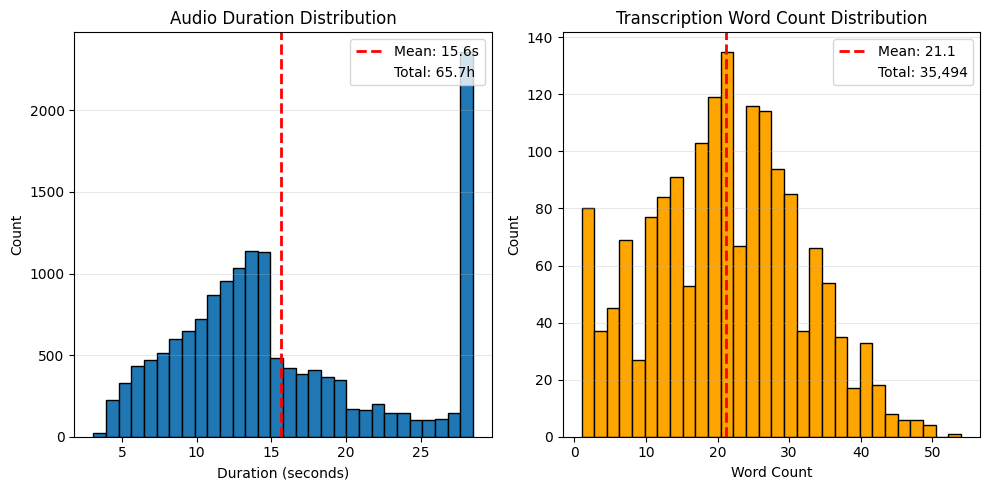

In [37]:
plot_distribution_graphs(sampled1_df)

In [49]:
# Remove poor alignment (wer > 6%)
sampled2_df = sampled2_df[sampled2_df["wer"] <= 0.06]

aligned_mask = sampled2_df["wer"] == 0.0
len_aligned_recordings = len(sampled2_df[aligned_mask])
aligned_duration = sampled2_df[aligned_mask]["duration"].sum() / 3600

total_recordings = len(sampled2_df)
not_aligned_duration = sampled2_df[~aligned_mask]["duration"].sum() / 3600

print(f"Total duration of the sample: {sampled2_df["duration"].sum() / 3600:.2f} hours")
print(
    f"Audio and transcription aligned recordings: {len_aligned_recordings:,} - {aligned_duration:.2f} hours")
print(
    f"Remaining recordings: {total_recordings - len_aligned_recordings:,} - {not_aligned_duration:.2f} hours")

sampled2_df.to_csv(SAMPLED_DATA2_PATH, index_label="id")
sampled2_df.describe()

Total duration of the sample: 45.13 hours
Audio and transcription aligned recordings: 4,761 - 16.31 hours
Remaining recordings: 5,418 - 28.82 hours


,duration,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
count,10179.000000,10179.000000,10179.000000,10179.000000,10179.000000,10179.000000
mean,15.962360,0.021253,0.007418,0.977816,31.039493,31.156499
std,7.872309,0.021793,0.010837,0.101770,16.471475,16.548795
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.050000,0.000000,0.000000,0.991600,19.000000,19.000000
50%,13.480000,0.018500,0.003000,0.998100,26.000000,26.000000
75%,23.180000,0.041700,0.011400,1.000000,43.000000,43.000000
max,28.500000,0.060000,0.124000,1.000000,94.000000,97.000000


In [50]:
# Add two validation and test sets
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")
val_test1_df = pd.read_csv(os.path.join(DATASET_DIR, "validation_test_sets.csv"), index_col="id")
val_test2_df = pd.read_csv(os.path.join(DATASET_DIR, "validation_test_sets2.csv"), index_col="id")

all_val_test_df = pd.concat([val_test1_df, val_test2_df], ignore_index=True)

# Remove samples that already belong to validation or test sets
sampled2_df = sampled2_df[~sampled2_df["path"].isin(all_val_test_df["path"])]
sampled2_df["type"] = "train"

sampled2_df = pd.concat([sampled2_df, all_val_test_df], ignore_index=True)

# Reorder columns
cols = list(sampled2_df.columns)
cols.remove("type")
cols.insert(2, "type")
sampled2_df = sampled2_df[cols]

sampled2_df.to_csv(SAMPLED_DATA2_PATH, index_label="id")
sampled2_df.describe()

,duration,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
count,10519.000000,10519.000000,10519.000000,10519.000000,10519.000000,10519.000000
mean,15.902511,0.023316,0.008244,0.976566,30.829927,30.951611
std,7.782299,0.027892,0.013669,0.103958,16.342522,16.415469
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.090000,0.000000,0.000000,0.991100,19.000000,19.000000
50%,13.530000,0.019200,0.003300,0.998000,26.000000,26.000000
75%,22.530000,0.041700,0.011900,1.000000,42.000000,42.000000
max,28.500000,0.303000,0.382400,1.000000,94.000000,97.000000


In [51]:
print(f"Total sampled 2 duration: {sampled2_df["duration"].sum() / 3600:.2f}h")
(sampled2_df.groupby("type")["duration"].sum() / 3600).sort_values(ascending=False)

Total sampled 2 duration: 46.47h


type
train         44.004025
test           1.355555
validation     1.106672
Name: duration, dtype: float64

In [69]:
# from pathlib import Path
import shutil

audio_names = set(pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")["path"])

for audio_name in audio_names:
    source_path = os.path.join(CHUNKED_AUDIO_DIR, audio_name)
    destination_path = os.path.join(SAMPLED_AUDIO_DIR, audio_name)
    shutil.copy(source_path, destination_path)

print(f"Copied {len(audio_names):,} audio files to {SAMPLED_AUDIO_DIR}")

Copied 11,825 audio files to ../datasets/news_youtube_uzbek_speech_dataset/data/sampled_audio


In [75]:
import glob

sampled1_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

sampled_audios1 = set(sampled1_df["path"])
sampled_audios2 = set(sampled2_df["path"])
all_audio_paths_sampled = sampled_audios1.union(sampled_audios2)

all_audio_paths_available = set(
    map(lambda full_path: Path(full_path).name, glob.glob(os.path.join(SAMPLED_AUDIO_DIR, "*.wav")))
)

missing_audio_paths = all_audio_paths_sampled - all_audio_paths_available
audio_paths_to_remove = all_audio_paths_available - all_audio_paths_sampled

extract_and_normalize_audio_from_parquet(missing_audio_paths)

for filename in audio_paths_to_remove:
    path = os.path.join(SAMPLED_AUDIO_DIR, filename)
    os.remove(path)

print(f"Removed unnecessary {len(audio_paths_to_remove):,} audio files")

Need to extract 20 audio files
Found 34 parquet files. Started processing...



Processing files: 100%|██████████| 34/34 [00:42<00:00,  1.26s/it]


Extracted and normalized 20 audio files to ../datasets/news_youtube_uzbek_speech_dataset/data/sampled_audio
Removed unnecessary 0 audio files


In [79]:
sampled1_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")
aligned_recordings_in_train = (sampled1_df["type"] == "train") & (sampled1_df["wer"] == 0.0)
previous_sample_to_augment = sampled1_df[aligned_recordings_in_train]
print(f"About to augment {previous_sample_to_augment["duration"].sum() / 3600:.2f} hours of previous data")

About to augment 1.84 hours of previous data


In [80]:
from scripts.audio_augmentation import AugmentationType, augment_dataset

audio_paths = previous_sample_to_augment["path"].apply(
    lambda filename: os.path.join(SAMPLED_AUDIO_DIR, filename)).tolist()

augmentation_types = [
    AugmentationType.SPEED | AugmentationType.NOISE,
    AugmentationType.PITCH | AugmentationType.TIME_MASK,
    AugmentationType.SPEED | AugmentationType.PITCH | AugmentationType.NOISE,
    AugmentationType.SPEED | AugmentationType.PITCH | AugmentationType.TIME_MASK,
]

augmentation_df = augment_dataset(
    audio_paths,
    SAMPLED_AUDIO_DIR,
    augmentation_types,
    noise_prob=0.7,
    time_mask_prob=0.7,
    min_speed_rate=0.9,
    max_speed_rate=1.1
)
augmentation_df.to_csv(os.path.join(DATASET_DIR, "augmentation_log.csv"), index_label="id")
augmentation_df

Processing files...: 100%|██████████| 598/598 [01:41<00:00,  5.92it/s]


Saved log to ../datasets/news_youtube_uzbek_speech_dataset/data/sampled_audio/augmentation_log.csv


,original_path,augmented_path,original_duration,augmented_duration,speed_applied,speed_rate_applied,pitch_applied,noise_applied,time_mask_applied,augmentation_type
0,00000007.wav,00000007_augmented_spd_nse.wav,7.650,7.9078,True,0.9674,False,True,False,AugmentationType.SPEED|NOISE
1,00000007.wav,00000007_augmented_pch_msk.wav,7.650,7.6500,False,1.0000,True,False,False,AugmentationType.PITCH|TIME_MASK
2,00000007.wav,00000007_augmented_spd_pch_nse.wav,7.650,8.1473,True,0.9390,True,True,False,AugmentationType.SPEED|PITCH|NOISE
3,00000007.wav,00000007_augmented_spd_pch_msk.wav,7.650,8.1472,True,0.9390,True,False,True,AugmentationType.SPEED|PITCH|TIME_MASK
4,00000062.wav,00000062_augmented_spd_nse.wav,9.968,9.7736,True,1.0199,False,False,False,AugmentationType.SPEED|NOISE
...,...,...,...,...,...,...,...,...,...,...
2387,00020719.wav,00020719_augmented_spd_pch_msk.wav,12.740,11.8453,True,1.0755,True,False,True,AugmentationType.SPEED|PITCH|TIME_MASK
2388,00020755.wav,00020755_augmented_spd_nse.wav,16.810,18.2572,True,0.9207,False,False,False,AugmentationType.SPEED|NOISE
2389,00020755.wav,00020755_augmented_pch_msk.wav,16.810,16.8100,False,1.0000,True,False,True,AugmentationType.PITCH|TIME_MASK
2390,00020755.wav,00020755_augmented_spd_pch_nse.wav,16.810,16.5157,True,1.0178,True,True,False,AugmentationType.SPEED|PITCH|NOISE


In [ ]:
augmentation_log_df = pd.read_csv(os.path.join(DATASET_DIR, "augmentation_log.csv"))
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

previous_sample_to_augment["type"] = "train"
# Fix path and duration
augmented_df = previous_sample_to_augment.merge(
    augmentation_log_df[["original_path", "augmented_path", "augmented_duration"]],
    left_on="path",
    right_on="original_path",
    how="left"
)

augmented_df.drop(columns=["duration", "original_path", "path", "char_count", "word_count"], inplace=True)
augmented_df.rename(columns={"augmented_path": "path", "augmented_duration": "duration"}, inplace=True)

cols = list(augmented_df.columns)
cols.remove("path")
cols.insert(0, "path")
cols.remove("duration")
cols.insert(2, "duration")
augmented_df = augmented_df[cols]

augmented_df = augmented_df[augmented_df["duration"] < 30]

sampled2_df = pd.concat([sampled2_df, augmented_df], ignore_index=True)

sampled2_df.to_csv(SAMPLED_DATA2_PATH, index_label="id")

In [88]:
augmented_mask = sampled2_df["path"].str.contains("augmented", regex=False)
print(f"Total sampled duration: {sampled2_df["duration"].sum() / 3600:.2f}h")
print(f"Augmented duration: {sampled2_df[augmented_mask]["duration"].sum() / 3600:.2f}h")
(sampled2_df.groupby("type")["duration"].sum() / 3600).sort_values(ascending=False)

Total sampled duration: 54.29h
Augmented duration: 7.82h


type
train         51.826843
test           1.355555
validation     1.106672
Name: duration, dtype: float64

/tmp/ipykernel_44379/2342941941.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled2_df["word_count"] = sampled2_df["ref_word_count"]


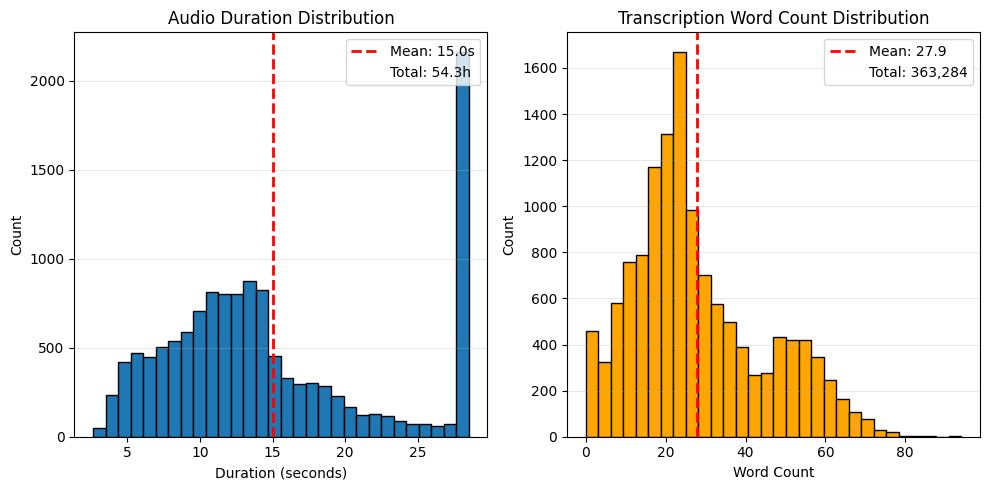

,path,duration,type,text_spt,text_original,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count,word_count
0,00004289_0.wav,10.6700,train,128 million 177 500 so'm pul hamda 2016-yil 24...,"bir yuz yigirma sakkiz million, bir yuz yetmis...",bir yuz yigirma sakkiz million bir yuz yetmish...,bir yuz yigirma sakkiz million bir yuz yetmish...,0.0000,0.0000,1.0000,23,23,23
1,00004314_0.wav,21.2200,train,Jazoni umumiy tartibli koloniyalarda o'tash ta...,jazoni umumiy tartibli koloniyalarda oʻtash ta...,jazoni umumiy tartibli koloniyalarda o'tash ta...,jazoni umumiy tartibli koloniyalarda o'tash ta...,0.0278,0.0033,0.9967,36,36,36
2,00004317_0.wav,10.6400,train,128 million 177 500 so'm pul hamda 2016-yil 24...,"Bir yuz yigirma sakkiz million, bir yuz yetmis...",bir yuz yigirma sakkiz million bir yuz yetmish...,bir yuz yigirma sakkiz million bir yuz yetmish...,0.0000,0.0000,1.0000,23,23,23
3,00004323_0.wav,26.5900,train,Soliyev Laziz Abdullayevichga O'zbekiston Resp...,Soliyev Glaziz Abdullayevichga Oʻzbekiston Res...,soliyev laziz abdullayevichga o'zbekiston resp...,soliyev glaziz abdullayevichga o'zbekiston res...,0.0566,0.0065,0.9817,53,53,53
4,00004329_1.wav,9.6400,train,"228-moddasi ikkinchi qismi a, b bandlari, 228-...","128-moddasi ikkinchi qismi A, B bandlari, 228-...",ikki yuz yigirma sakkizinchi moddasi ikkinchi ...,bir yuz yigirma sakkizinchi moddasi ikkinchi q...,0.0370,0.0231,0.9855,27,27,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14208,00020696_augmented_spd_pch_msk.wav,6.8593,train,Marhumning oilasi har oy o't o'chiruvchining n...,marhumning oilasi har oy oʻt oʻchiruvchining n...,marhumning oilasi har oy o't o'chiruvchining n...,marhumning oilasi har oy o't o'chiruvchining n...,0.0000,0.0000,1.0000,10,10,10
14211,00020719_augmented_spd_pch_nse.wav,12.1982,train,e'lonlarni davlat xaridlarining maxsus axborot...,e'lonlarni Davlat xaridlarining maxsus axborot...,e'lonlarni davlat xaridlarining maxsus axborot...,e'lonlarni davlat xaridlarining maxsus axborot...,0.0000,0.0000,1.0000,21,21,21
14212,00020719_augmented_spd_pch_msk.wav,11.8453,train,e'lonlarni davlat xaridlarining maxsus axborot...,e'lonlarni Davlat xaridlarining maxsus axborot...,e'lonlarni davlat xaridlarining maxsus axborot...,e'lonlarni davlat xaridlarining maxsus axborot...,0.0000,0.0000,1.0000,21,21,21
14215,00020755_augmented_spd_pch_nse.wav,16.5157,train,gvardiya xodimlari pichoqlangani va o'lim ro'y...,gvardiya xodimlari pichoqlangani va oʻlim roʻy...,gvardiya xodimlari pichoqlangani va o'lim ro'y...,gvardiya xodimlari pichoqlangani va o'lim ro'y...,0.0000,0.0000,1.0000,34,34,34


In [90]:
sampled2_df["word_count"] = sampled2_df["ref_word_count"]
plot_distribution_graphs(sampled2_df)
sampled2_df

In [9]:
sampled1_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

train_paths = set(sampled1_df[sampled1_df["type"] == "train"]["path"])
val_paths = set(sampled1_df[sampled1_df["type"] == "validation"]["path"])
test_paths = set(sampled1_df[sampled1_df["type"] == "test"]["path"])

print(f"\nOverlap Train/Val: {len(train_paths.intersection(val_paths))}")
print(f"Overlap Train/Test: {len(train_paths.intersection(test_paths))}")
print(f"Overlap Val/Test: {len(val_paths.intersection(test_paths))}")


Overlap Train/Val: 0
Overlap Train/Test: 0
Overlap Val/Test: 0


In [13]:
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

train_paths = set(sampled2_df[sampled2_df["type"] == "train"]["path"].apply(
    lambda filename: filename.split("_augmented")[0] if "_augmented" in filename else filename)
)
val_paths = set(sampled2_df[sampled2_df["type"] == "validation"]["path"])
test_paths = set(sampled2_df[sampled2_df["type"] == "test"]["path"])

print(f"\nOverlap Train/Val: {len(train_paths.intersection(val_paths))}")
print(f"Overlap Train/Test: {len(train_paths.intersection(test_paths))}")
print(f"Overlap Val/Test: {len(val_paths.intersection(test_paths))}")


Overlap Train/Val: 0
Overlap Train/Test: 0
Overlap Val/Test: 0


Later, I discovered that my validation and test sets are biased and not represent entire dataset. I sampled the first set to be manually checked by filtering out the 200 samples with 0 < WER <= 20%, and additional 150 top WER scores with previous condition.
```python
misaligned_df = sampled_df[(sampled_df["wer"] > 0) & (sampled_df["wer"] <= 0.20)]
first_check = misaligned_df.sample(200, random_state=SEED)
# Get the Top WER Sample (excluding the random ones)
top_wer_sample = misaligned_df.drop(random_sample.index).nlargest(150, "wer")
to_manually_check_df = pd.concat([random_sample, top_wer_sample])
to_manually_check_df.to_csv(os.path.join(DATASET_DIR, "check_alignment_manually.csv"), index_label="id") # 1.33 hours
```

In the second sampling to be manually checked and then added as validation and test sets, I used similar strategy (this time WER >= 6%):
```python
misaligned_df = sampled2_df[sampled2_df["wer"] > 0]
random_sample = misaligned_df.sample(150, random_state=SEED)
# Get the Top WER Sample (excluding the random ones)
top_wer_sample = misaligned_df.drop(random_sample.index).nlargest(50, "wer")
to_manually_check_df = pd.concat([random_sample, top_wer_sample])
to_manually_check_df.to_csv(os.path.join(DATASET_DIR, "check_alignment_manually2.csv"), index_label="id") # 1.12 hours
```

I tried to sample third set that tries to cover the under-represented part of the News dataset with WER > 20% (totaling: 23 minutes)

In [129]:
# from scripts import similarity_metrics

all_data_df = pd.read_csv(ALL_DATA_PATH, index_col="id")
chunked_df = pd.read_csv(os.path.join(DATASET_DIR, "chunked_data.csv"))
stt_transcriptions1 = pd.read_csv(TRANSCRIPTION_RESULTS_PATH, index_col="id")
stt_transcriptions2 = pd.read_csv(TRANSCRIPTION_RESULTS2_PATH, index_col="id")
gemini_transcriptions = pd.read_csv(os.path.join(DATASET_DIR, "gemini_pro_transcriptions.csv"), index_col="id")

# Get the first transcriptions (it was before chunking)
stt_transcriptions1.rename(columns={"predicted_sentence": "text_spt"}, inplace=True)
stt_transcriptions1 = stt_transcriptions1.merge(
    all_data_df[["path", "text_original", "duration"]],
    left_on="path",
    right_on="path",
    how="left"
)
stt_transcriptions1.drop(columns=["error_message", "error_type"], inplace=True)

# Original text preserved on not chunked samples. Merge them back
not_chunked_paths = set(chunked_df[chunked_df.groupby("path")["chunk_path"].transform("count") == 1]["path"])
not_chunked_df = all_data_df[all_data_df["path"].isin(not_chunked_paths)]
not_chunked_df["path"] = not_chunked_df["path"].str.replace(".wav", "_0.wav")

stt_transcriptions2 = stt_transcriptions2.merge(
    not_chunked_df[["path", "text_original"]],
    left_on="chunk_path",
    right_on="path",
    how="left",
    suffixes=("", "_new")
)
stt_transcriptions2.drop(columns=["path", "path_new", "error_message", "error_type"], inplace=True)

# Get duration column from chunked_df
stt_transcriptions2 = stt_transcriptions2.merge(
    chunked_df[["chunk_path", "duration"]],
    left_on="chunk_path",
    right_on="chunk_path",
    how="left",
    suffixes=("", "_new")
)

# Get Gemini predicted column
gemini_transcriptions.rename(columns={"predicted_sentence": "text_original"}, inplace=True)
stt_transcriptions2 = stt_transcriptions2.merge(
    gemini_transcriptions[["path", "text_original"]],
    left_on="chunk_path",
    right_on="path",
    how="left",
    suffixes=("", "_new")
)
stt_transcriptions2.drop(columns=["path"], inplace=True)
stt_transcriptions2.rename(columns={"chunk_path": "path", "predicted_sentence": "text_spt"}, inplace=True)
stt_transcriptions2["text_original"] = stt_transcriptions2["text_original"].fillna(
    stt_transcriptions2["text_original_new"])

overall_news = pd.concat([stt_transcriptions1, stt_transcriptions2], ignore_index=True)
interested_cols = ["path", "duration", "text_spt", "text_original"]
overall_news = overall_news[interested_cols]

# Apply similarity metrics to each row
metrics = overall_news.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["text_spt"],  # Google SPT generated text (should be more accurate)
        hypothesis=row["text_original"],  # Gemini 2.5 Pro generated text
    ),
    axis=1
)

# Convert list of dicts → DataFrame
metrics_df = pd.DataFrame(metrics.tolist(), overall_news.index)

# Merge metric columns back into main DataFrame and save
overall_news = pd.concat([overall_news, metrics_df], axis=1)

# Just remove too extreme outliers
overall_news = overall_news[~overall_news["hyp_normalized"].str.contains("json")]

print("Overall News dataset statistics:")
print(f"Total duration: {overall_news["duration"].sum() / 3600:.2f} hours")
print(overall_news[["duration", "wer"]].describe())

overall_news.to_csv(os.path.join(DATASET_DIR, "overall_news.csv"), index_label="id")
overall_news.sort_values("wer", ascending=False)

/tmp/ipykernel_12674/3050422541.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_chunked_df["path"] = not_chunked_df["path"].str.replace(".wav", "_0.wav")


Overall News dataset statistics:
Total duration: 136.51 hours
           duration          wer
count  32043.000000  32043.00000
mean      15.336436      0.56004
std        7.347232      3.32987
min        3.013500      0.00000
25%       10.010000      0.04000
50%       13.450000      0.09760
75%       19.600000      0.18750
max       28.500000     88.00000


,path,duration,text_spt,text_original,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
5185,00010984_0.wav,28.500000,NaN,yana ham qanaqadir dori aytyapti deb siz Xoros...,,yana ham qanaqadir dori aytyapti deb siz xoros...,88.0,517.0,0.0,0,88
3385,00004888_0.wav,28.480000,NaN,lyudi volnuyutsya... Pochemu? Potomu chto nu p...,,lyudi volnuyutsya pochemu potomu chto nu posle...,76.0,523.0,0.0,0,76
15520,00004946_0.wav,28.450000,NaN,"My... u nas yedinstvenno to, chto my... vot et...",,my u nas yedinstvenno to chto my vot etot o'rt...,75.0,505.0,0.0,0,75
3725,00011236_0.wav,28.410000,NaN,"i te mesta yeshche ne byli zapolneny, to logic...",,i te mesta yeshche ne byli zapolneny to logich...,73.0,495.0,0.0,0,73
3391,00004889_0.wav,28.480000,NaN,vas v formativka organizdan keyin ya znayu u m...,,vas v formativka organizdan keyin ya znayu u m...,71.0,445.0,0.0,0,71
...,...,...,...,...,...,...,...,...,...,...,...
18750,00014749_0.wav,4.410000,But everything with cooperation with the,but everything with cooperation with the,but everything with cooperation with the,but everything with cooperation with the,0.0,0.0,1.0,6,6
10129,00013786_1.wav,9.670000,16-yilda Toshkent shahar sudini hukmiga ko'ra ...,oʻn oltinchi yilda Toshkent shahar sudini hukm...,o'n oltinchi yilda toshkent shahar sudini hukm...,o'n oltinchi yilda toshkent shahar sudini hukm...,0.0,0.0,1.0,13,13
10128,00013778_0.wav,28.490000,Bugun vatanga olib kelingan bolalar orasida ha...,Bugun vatanga olib kelingan bolalar orasida ha...,bugun vatanga olib kelingan bolalar orasida ha...,bugun vatanga olib kelingan bolalar orasida ha...,0.0,0.0,1.0,13,13
10126,00013786_0.wav,13.420000,9 yil ozodlikdan mahrum etilganman. 8 yil-u 2 ...,toʻqqiz yil ozodlikdan mahrum etilganman. Sakk...,to'qqiz yil ozodlikdan mahrum etilganman sakki...,to'qqiz yil ozodlikdan mahrum etilganman sakki...,0.0,0.0,1.0,29,29


In [130]:
first_check = pd.read_csv(os.path.join(DATASET_DIR, "news_dataset_checked.csv"), index_col="id")
print("First manually checked sample statistics:")
print(f"Total duration: {first_check["duration"].sum() / 3600:.2f} hours")
print(first_check[["duration", "wer"]].describe())
print()

second_check = pd.read_csv(os.path.join(DATASET_DIR, "news_dataset_checked2.csv"), index_col="id")
print("Second manually checked sample statistics:")
print(f"Total duration: {second_check["duration"].sum() / 3600:.2f} hours")
print(second_check[["duration", "wer"]].describe())
print()

# Only sample WER > 0.20. Don't include WER == 0.0 because these samples already trained
to_manually_check3 = overall_news[overall_news["wer"] > 0.20].sample(150, random_state=SEED)
to_manually_check3.to_csv(os.path.join(DATASET_DIR, "check_alignment_manually3.csv"), index_label="id")

print("Third sampled set to manually check statistics:")
print(f"Total duration: {to_manually_check3["duration"].sum() / 3600:.2f} hours")
print(to_manually_check3[["duration", "wer"]].describe())

to_manually_check3

First manually checked sample statistics:
Total duration: 1.38 hours
         duration         wer
count  350.000000  350.000000
mean    14.179901    0.142349
std      3.871147    0.056029
min      4.186687    0.025000
25%     11.016672    0.095200
50%     14.565344    0.166700
75%     17.501328    0.190500
max     19.984000    0.200000

Second manually checked sample statistics:
Total duration: 1.13 hours
         duration         wer
count  200.000000  200.000000
mean    20.331850    0.044560
std      7.685038    0.014075
min      7.230000    0.014900
25%     12.660000    0.033300
50%     21.045000    0.047600
75%     28.440000    0.058800
max     28.500000    0.060000

Third sampled set to manually check statistics:
Total duration: 0.59 hours
         duration         wer
count  150.000000  150.000000
mean    14.248872    2.573823
std      6.969548    7.186630
min      4.270000    0.203700
25%      9.620000    0.244300
50%     12.592000    0.292900
75%     16.335000    0.509600
max 

,path,duration,text_spt,text_original,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
22663,00007736_1.wav,13.28,baligi oratorlik ustidan keyin tursa kerak ora...,haligi oratorskiy vystupleniyadan keyin tursa ...,baligi oratorlik ustidan keyin tursa kerak ora...,haligi oratorskiy vystupleniyadan keyin tursa ...,0.3448,0.1884,0.5548,29,32
31037,00010332_0.wav,13.07,Tushunmadim men sizlarni. Bo'ldi qaror tushuna...,Tushunmadim men sizlarni. qaror ustida eshitdi...,tushunmadim men sizlarni bo'ldi qaror tushunar...,tushunmadim men sizlarni qaror ustida eshitdik...,0.4167,0.4175,0.8273,12,17
2776,00004390_1.wav,9.86,"Suldash, Sherzod, Shuhratjon nomiga rasmiylash...",Sudlanuvchi Dusshanov Sherzod Shuqurovjon o'g'...,suldash sherzod shuhratjon nomiga rasmiylashti...,sudlanuvchi dusshanov sherzod shuqurovjon o'g'...,0.3125,0.2086,0.8800,16,18
24262,00013004_0.wav,22.88,"berishi mumkinki, Nodirbekka juda ham katta im...","kafolat berishim mumkinki, Nodirbekki judayam ...",berishi mumkinki nodirbekka juda ham katta imk...,kafolat berishim mumkinki nodirbekki judayam k...,0.2500,0.0743,0.8107,28,28
28681,00017306_0.wav,16.20,NaN,kak etapma-etap qabul qilishdi. To est u nas i...,,kak etapma-etap qabul qilishdi to est u nas in...,37.0000,250.0000,0.0000,0,37
...,...,...,...,...,...,...,...,...,...,...,...
18666,00002429_1.wav,9.30,Endi men bu voqeani telefonda menga xabar qili...,Endi mana bu voqeani telefonda menga xabar qil...,endi men bu voqeani telefonda menga xabar qili...,endi mana bu voqeani telefonda menga xabar qil...,0.3889,0.0846,0.9549,18,20
7747,00016386_0.wav,11.68,davlat xizmatlari markazlari tomonidan avval b...,yamanligi Davlat xizmatlari markazlari tomonid...,davlat xizmatlari markazlari tomonidan avval b...,yamanligi davlat xizmatlari markazlari tomonid...,0.2105,0.1156,0.9379,19,20
31880,00019440_0.wav,10.14,A takje vvelo moratoriy na povishenie cen na s...,a takje ijtimoiy ahamiyatga ega oziq-ovqat mah...,a takje vvelo moratoriy na povishenie cen na s...,a takje ijtimoiy ahamiyatga ega oziq-ovqat mah...,0.9444,0.8105,0.1750,18,19
2837,00004443_0.wav,13.98,NaN,"topshiraman 15-kuni, oradan yana besh kun oʻti...",,topshiraman o'n beshinchi kuni oradan yana bes...,32.0000,229.0000,0.0000,0,32


In [137]:
third_check = pd.read_csv(os.path.join(DATASET_DIR, "news_dataset_checked3.csv"), index_col="id")
third_check = third_check[~third_check["sentence_checked"].isna()]
print("Third manually checked sample statistics:")
print(f"Total duration: {third_check["duration"].sum() / 3600:.2f} hours")
print(third_check[["duration", "wer"]].describe())
print()

all_checked = pd.concat([first_check, second_check, third_check], ignore_index=True)
all_checked = all_checked[~all_checked["sentence_checked"].isna()]

# Recalculate Google STT vs Gemini WER
all_checked = all_checked[["path", "duration", "sentence_checked", "text_spt", "text_original"]]
all_metrics = all_checked.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["text_spt"],
        hypothesis=row["text_original"],
    ),
    axis=1
)
all_metrics = pd.DataFrame(all_metrics.tolist(), all_checked.index)
all_checked = pd.concat([all_checked, all_metrics], axis=1)

print("All manually checked statistics:")
print(f"Total duration: {all_checked["duration"].sum() / 3600:.2f} hours")
print(all_checked[["duration", "wer"]].describe())

all_checked.sort_values("wer", ascending=False)

Third manually checked sample statistics:
Total duration: 0.37 hours
         duration         wer
count  100.000000  100.000000
mean    13.452617    2.035941
std      6.923344    5.908834
min      4.270000    0.203700
25%      8.065000    0.236425
50%     11.805000    0.290300
75%     15.080000    0.426150
max     28.500000   37.000000

All manually checked statistics:
Total duration: 2.84 hours
         duration         wer
count  640.000000  640.000000
mean    15.952002    0.406448
std      6.528452    2.430098
min      4.186687    0.000000
25%     11.040000    0.052600
50%     14.660687    0.120600
75%     19.130688    0.200000
max     28.500000   37.000000


,path,duration,sentence_checked,text_spt,text_original,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
554,00017306_0.wav,16.200000,Etapma-etap qabul qilishdi. To est u nas indek...,NaN,kak etapma-etap qabul qilishdi. To est u nas i...,,kak etapma-etap qabul qilishdi to est u nas in...,37.0000,250.0000,0.0000,0,37
632,00012412_0.wav,11.990000,U yerda aktyorlar kelardi. U yerda politiklar ...,NaN,U yerda aktyorlar kelardi. U yerda politiklar ...,,u yerda aktyorlar kelardi u yerda politiklar k...,26.0000,188.0000,0.0000,0,26
583,00001405_1.wav,8.080000,"Ulan, kecha Grammy olgan Murodni birinchi inte...",NaN,"Ulan, kecha Grammy olgan Murodni birinchi inte...",,ulan kecha grammy olgan murodni birinchi inter...,22.0000,142.0000,0.0000,0,22
604,00015096_1.wav,10.920000,"Demak, bu ushlanishlar davomida ikkita bir mas...",NaN,"Pretsedent, demak, bu eshitishlar davomida ikk...",,pretsedent demak bu eshitishlar davomida ikkit...,20.0000,139.0000,0.0000,0,20
617,00015964_0.wav,7.250000,demak mana odatda bu competency-based intervie...,NaN,demak mana odatda bu competency-based intervie...,,demak mana odatda bu competency-based intervie...,18.0000,110.0000,0.0000,0,18
...,...,...,...,...,...,...,...,...,...,...,...,...
364,00010032_0.wav,28.450000,"O'zi shunaqa qiyin masala. A-ha, kecha men ayr...","a-a, kecha men ayrim xorijiy ekspertlar bilan,...",masalan. Kecha men ayrim xorijiy ekspertlar bi...,a-a kecha men ayrim xorijiy ekspertlar bilan i...,masalan kecha men ayrim xorijiy ekspertlar bil...,0.0161,0.0108,0.9892,62,62
366,00009781_0.wav,28.500000,"xorijiy valyutani yashirish, deklaratsiyalarda...","xorijiy valyutani yashirish, deklaratsiyalarda...",xorijiy valyutani yashirish. Deklaratsiyalarda...,xorijiy valyutani yashirish deklaratsiyalarda ...,xorijiy valyutani yashirish deklaratsiyalarda ...,0.0152,0.0041,0.9970,66,66
422,00002980_0.wav,28.490000,"qimmatroq turadi. Agar anglagan bo'lsangiz, in...","qimmatroq turadi. Agar anglagan bo'lsangiz, in...","qimmatroq turadi. Agar anglagan bo'lsangiz, in...",qimmatroq turadi agar anglagan bo'lsangiz inso...,qimmatroq turadi agar anglagan bo'lsangiz inso...,0.0149,0.0057,0.9953,67,67
25,00000409.wav,6.832000,"Sekin-sekin o'rganib, o'sha aytganimdek karyer...","Sekin-sekin o'rganib, o'sha aytganimdek karyer...","sekin-sekin o'rganib, o'sha aytganimdek karyer...",sekin-sekin o'rganib o'sha aytganimdek karyera...,sekin-sekin o'rganib o'sha aytganimdek karyera...,0.0000,0.0000,1.0000,7,7


In [138]:
google_spt_metrics = all_checked.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["sentence_checked"],
        hypothesis=row["text_spt"],  # Google SPT generated text
    ),
    axis=1
)
google_spt_metrics = pd.DataFrame(google_spt_metrics.tolist(), all_checked.index)

gemini_metrics = all_checked.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["sentence_checked"],
        hypothesis=row["text_original"],  # Gemini 2.5 Pro generated text
    ),
    axis=1
)
gemini_metrics = pd.DataFrame(gemini_metrics.tolist(), all_checked.index)

print(f"Manually checked total duration: {all_checked["duration"].sum() / 3600:.2f} hours")
print(f"Original WER - Google SPT to Gemini 2.5 Pro: {all_checked["wer"].mean() * 100:.2f}%")
print(f"Estimated WER of Google SPT: {google_spt_metrics["wer"].mean() * 100:.2f}%")
print(f"Estimated WER of Gemini 2.5 Pro: {gemini_metrics["wer"].mean() * 100:.2f}%")

google_spt_metrics.sort_values("wer", ascending=False)

Manually checked total duration: 2.84 hours
Original WER - Google SPT to Gemini 2.5 Pro: 40.64%
Estimated WER of Google SPT: 9.22%
Estimated WER of Gemini 2.5 Pro: 8.89%


,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
579,ko'rsatma xat ministerstvo zdravo ministerstvo...,,1.0,1.0,0.0,8,0
583,ulan kecha grammy olgan murodni birinchi inter...,,1.0,1.0,0.0,22,0
584,va toje samo uchinchi anavi karantinga shayx i...,,1.0,1.0,0.0,15,0
554,etapma-etap qabul qilishdi to est u nas indeks...,,1.0,1.0,0.0,36,0
631,[musiqa],,1.0,1.0,0.0,1,0
...,...,...,...,...,...,...,...
25,sekin-sekin o'rganib o'sha aytganimdek karyera...,sekin-sekin o'rganib o'sha aytganimdek karyera...,0.0,0.0,1.0,7,7
1,sherali jo'rayev nomini qoralamaslikni iltimos...,sherali jo'rayev nomini qoralamaslikni iltimos...,0.0,0.0,1.0,34,34
0,xalq dushmaniga ham chiqarib yuborardida ya'ni...,xalq dushmaniga ham chiqarib yuborardida ya'ni...,0.0,0.0,1.0,27,27
29,saidjon bu borada mas'ul kotib temirov bilan h...,saidjon bu borada mas'ul kotib temirov bilan h...,0.0,0.0,1.0,27,27


In [149]:
third_check

,path,duration,text_spt,text_original,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count,sentence_checked
id,,,,,,,,,,,,
22663,00007736_1.wav,13.28,baligi oratorlik ustidan keyin tursa kerak ora...,haligi oratorskiy vystupleniyadan keyin tursa ...,baligi oratorlik ustidan keyin tursa kerak ora...,haligi oratorskiy vystupleniyadan keyin tursa ...,0.3448,0.1884,0.5548,29,32,"haligi, oratorlik vystupleniyadan keyin tursa ..."
31037,00010332_0.wav,13.07,Tushunmadim men sizlarni. Bo'ldi qaror tushuna...,Tushunmadim men sizlarni. qaror ustida eshitdi...,tushunmadim men sizlarni bo'ldi qaror tushunar...,tushunmadim men sizlarni qaror ustida eshitdik...,0.4167,0.4175,0.8273,12,17,Tushunmadim men sizlarni. Bo'ldi qaror tushuna...
2776,00004390_1.wav,9.86,"Suldash, Sherzod, Shuhratjon nomiga rasmiylash...",Sudlanuvchi Dusshanov Sherzod Shuqurovjon o'g'...,suldash sherzod shuhratjon nomiga rasmiylashti...,sudlanuvchi dusshanov sherzod shuqurovjon o'g'...,0.3125,0.2086,0.8800,16,18,Suldlanuvchi Dusshanov Sherzod Shukurjon o'g'l...
24262,00013004_0.wav,22.88,"berishi mumkinki, Nodirbekka juda ham katta im...","kafolat berishim mumkinki, Nodirbekki judayam ...",berishi mumkinki nodirbekka juda ham katta imk...,kafolat berishim mumkinki nodirbekki judayam k...,0.2500,0.0743,0.8107,28,28,"kafolat berishim mumkinki, Nodirbek aka juda h..."
28681,00017306_0.wav,16.20,NaN,kak etapma-etap qabul qilishdi. To est u nas i...,NaN,kak etapma-etap qabul qilishdi to est u nas in...,37.0000,250.0000,0.0000,0,37,Etapma-etap qabul qilishdi. To est u nas indek...
...,...,...,...,...,...,...,...,...,...,...,...,...
4168,00011539_1.wav,12.90,"Aminazinga o'xshagan narsami? Men o'zi prosta,...","U amin... aminazinga o'xshagan narsami, hozi p...",aminazinga o'xshagan narsami men o'zi prosta c...,u amin aminazinga o'xshagan narsami hozi prost...,0.4762,0.1534,0.9048,21,25,"Aminazinga o'xshagan narsami? Men o'zi prosta,..."
8384,00000863_1.wav,13.25,"Bu anaqa erishdik, dunyo bizga afsus qiladigan...","bu anaqaga erishdik, dunyo bizga outsource qil...",bu anaqa erishdik dunyo bizga afsus qiladigan ...,bu anaqaga erishdik dunyo bizga outsource qila...,0.2759,0.1448,0.5459,29,30,"Bu anaqaga erishdik, dunyo bizga outsource qil..."
28949,00017485_0.wav,6.98,yoki ulab beray sanga shunaqa veb-sayt zakaz q...,yoki ulab beray senga shunaqa vebsayt zakaz qi...,yoki ulab beray sanga shunaqa veb-sayt zakaz q...,yoki ulab beray senga shunaqa vebsayt zakaz qi...,0.2941,0.0702,0.9333,17,16,yoki ulab beray senga. Shunaqa veb-sayt zakaz ...


In [150]:
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")
sampled2_df

,path,duration,type,text_spt,text_original,ref_normalized,hyp_normalized,wer,cer,sequence_similarity,ref_word_count,hyp_word_count
id,,,,,,,,,,,,
0,00004289_0.wav,10.6700,train,128 million 177 500 so'm pul hamda 2016-yil 24...,"bir yuz yigirma sakkiz million, bir yuz yetmis...",bir yuz yigirma sakkiz million bir yuz yetmish...,bir yuz yigirma sakkiz million bir yuz yetmish...,0.0000,0.0000,1.0000,23,23
1,00004314_0.wav,21.2200,train,Jazoni umumiy tartibli koloniyalarda o'tash ta...,jazoni umumiy tartibli koloniyalarda oʻtash ta...,jazoni umumiy tartibli koloniyalarda o'tash ta...,jazoni umumiy tartibli koloniyalarda o'tash ta...,0.0278,0.0033,0.9967,36,36
2,00004317_0.wav,10.6400,train,128 million 177 500 so'm pul hamda 2016-yil 24...,"Bir yuz yigirma sakkiz million, bir yuz yetmis...",bir yuz yigirma sakkiz million bir yuz yetmish...,bir yuz yigirma sakkiz million bir yuz yetmish...,0.0000,0.0000,1.0000,23,23
3,00004323_0.wav,26.5900,train,Soliyev Laziz Abdullayevichga O'zbekiston Resp...,Soliyev Glaziz Abdullayevichga Oʻzbekiston Res...,soliyev laziz abdullayevichga o'zbekiston resp...,soliyev glaziz abdullayevichga o'zbekiston res...,0.0566,0.0065,0.9817,53,53
4,00004329_1.wav,9.6400,train,"228-moddasi ikkinchi qismi a, b bandlari, 228-...","128-moddasi ikkinchi qismi A, B bandlari, 228-...",ikki yuz yigirma sakkizinchi moddasi ikkinchi ...,bir yuz yigirma sakkizinchi moddasi ikkinchi q...,0.0370,0.0231,0.9855,27,27
...,...,...,...,...,...,...,...,...,...,...,...,...
14208,00020696_augmented_spd_pch_msk.wav,6.8593,train,Marhumning oilasi har oy o't o'chiruvchining n...,marhumning oilasi har oy oʻt oʻchiruvchining n...,marhumning oilasi har oy o't o'chiruvchining n...,marhumning oilasi har oy o't o'chiruvchining n...,0.0000,0.0000,1.0000,10,10
14211,00020719_augmented_spd_pch_nse.wav,12.1982,train,e'lonlarni davlat xaridlarining maxsus axborot...,e'lonlarni Davlat xaridlarining maxsus axborot...,e'lonlarni davlat xaridlarining maxsus axborot...,e'lonlarni davlat xaridlarining maxsus axborot...,0.0000,0.0000,1.0000,21,21
14212,00020719_augmented_spd_pch_msk.wav,11.8453,train,e'lonlarni davlat xaridlarining maxsus axborot...,e'lonlarni Davlat xaridlarining maxsus axborot...,e'lonlarni davlat xaridlarining maxsus axborot...,e'lonlarni davlat xaridlarining maxsus axborot...,0.0000,0.0000,1.0000,21,21


In [152]:
sampled2_df.groupby(["type"])["duration"].sum() / 3600

type
test           1.355555
train         51.826843
validation     1.106672
Name: duration, dtype: float64

In [155]:
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

manually_checked3_df = third_check[["path", "duration", "sentence_checked", "text_spt", "text_original"]]
google_spt_metrics = manually_checked3_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["sentence_checked"],
        hypothesis=row["text_spt"],  # Google SPT generated text
    ),
    axis=1
)
google_spt_metrics = pd.DataFrame(google_spt_metrics.tolist(), manually_checked3_df.index)

gemini_metrics = manually_checked3_df.apply(
    lambda row: similarity_metrics.calculate(
        reference=row["sentence_checked"],
        hypothesis=row["text_original"],  # Gemini 2.5 Pro generated text
    ),
    axis=1
)
gemini_metrics = pd.DataFrame(gemini_metrics.tolist(), manually_checked3_df.index)

manually_checked3_df["type"] = "test"
manually_checked3_df.drop(columns=["text_spt"], inplace=True)
manually_checked3_df.rename(columns={"sentence_checked": "text_spt"}, inplace=True)

manually_checked3_df = pd.concat([manually_checked3_df, gemini_metrics], axis=1)
sampled2_df = pd.concat([sampled2_df, manually_checked3_df], ignore_index=True)

print(f"Manually checked total duration: {manually_checked3_df["duration"].sum() / 3600:.2f} hours")
print(f"Original WER - Google SPT to Gemini 2.5 Pro: {manually_checked3_df["wer"].mean() * 100:.2f}%")
print(f"Estimated WER of Google SPT: {google_spt_metrics["wer"].mean() * 100:.2f}%")
print(f"Estimated WER of Gemini 2.5 Pro: {gemini_metrics["wer"].mean() * 100:.2f}%")

sampled2_df.to_csv(SAMPLED_DATA2_PATH, index_label="id")
sampled2_df.groupby(["type"])["duration"].sum() / 3600

Manually checked total duration: 0.37 hours
Original WER - Google SPT to Gemini 2.5 Pro: 19.07%
Estimated WER of Google SPT: 26.18%
Estimated WER of Gemini 2.5 Pro: 19.07%



/tmp/ipykernel_12674/3493317827.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manually_checked3_df["type"] = "test"
/tmp/ipykernel_12674/3493317827.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manually_checked3_df.drop(columns=["text_spt"], inplace=True)
/tmp/ipykernel_12674/3493317827.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manually_checked3_df.rename

type
test           1.729239
train         51.826843
validation     1.106672
Name: duration, dtype: float64

/tmp/ipykernel_12674/454905148.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


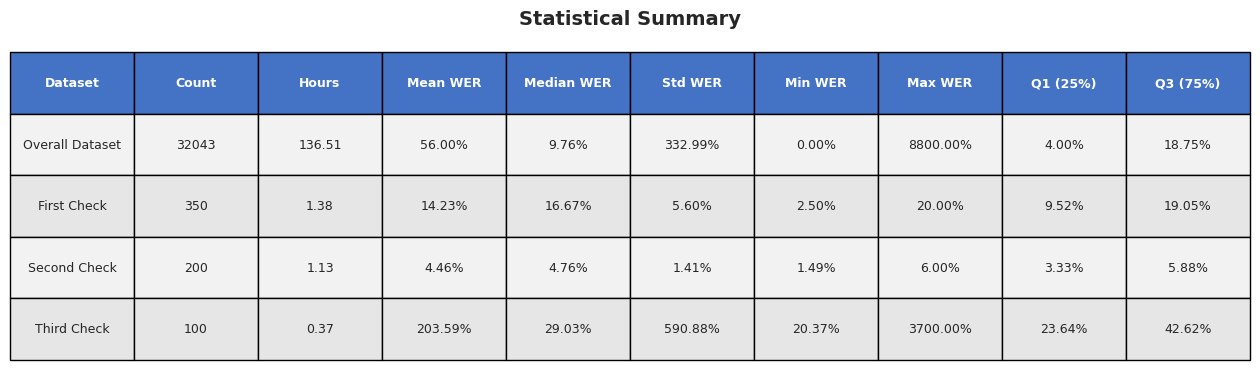

Note: identified 857 samples with WER > 100%, ignoring them when displaying


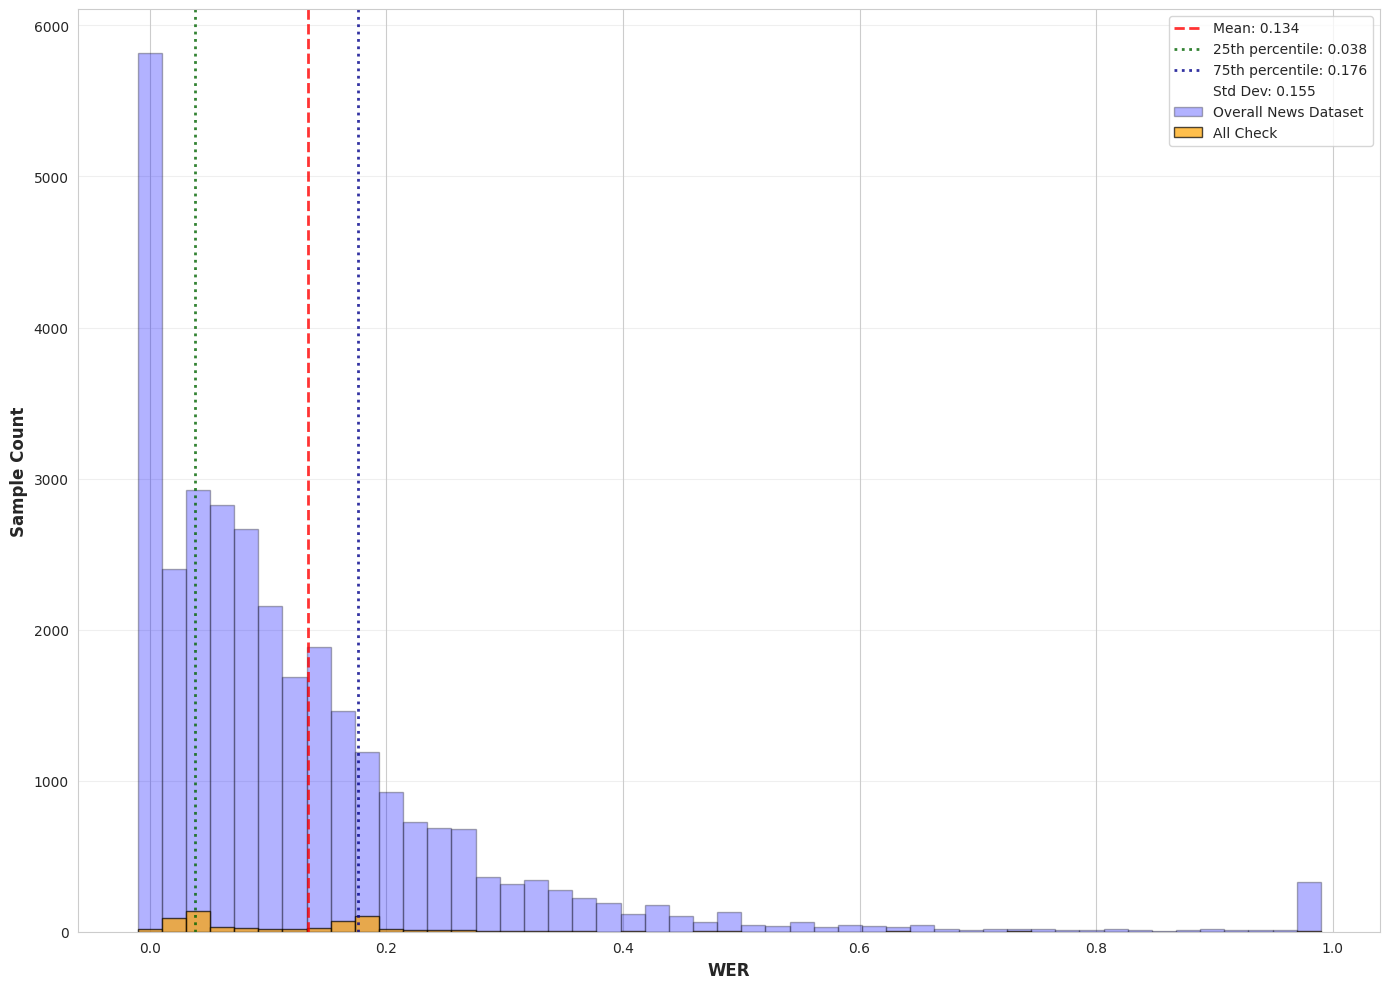

Note: identified 11 samples with WER > 100%, ignoring them when displaying


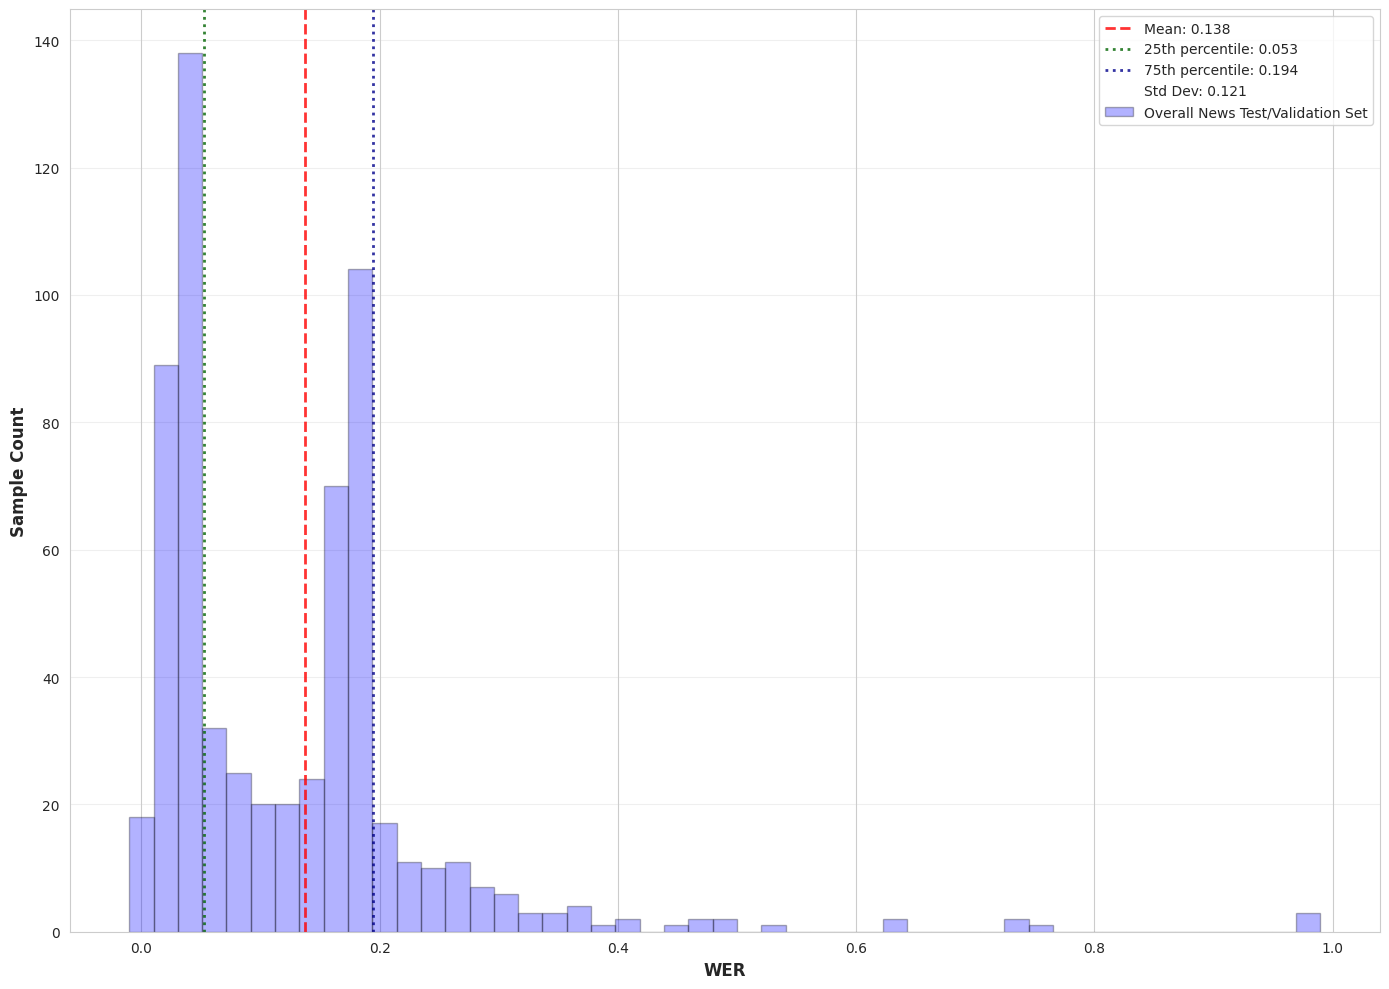

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


def plot_wer_distribution(
        overall_df,
        first_check_df=None,
        second_check_df=None,
        third_check_df=None,
        save_path=None,
        figsize=(16, 4)
):
    # Set style
    sns.set_style("whitegrid")
    plt.rcParams['font.size'] = 10

    # Create figure with subplots
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, 1, hspace=0.3, wspace=0.3)

    # ============================================================
    # Statistics table
    # ============================================================
    ax = fig.add_subplot(gs[0, 0])
    ax.axis('off')

    # Prepare statistics
    stats_data = []

    def calc_stats(df, name):
        return {
            'Dataset': name,
            'Count': len(df),
            'Hours': f"{df['duration'].sum() / 3600:.2f}",
            'Mean WER': f"{df['wer'].mean():.2%}",
            'Median WER': f"{df['wer'].median():.2%}",
            'Std WER': f"{df['wer'].std():.2%}",
            'Min WER': f"{df['wer'].min():.2%}",
            'Max WER': f"{df['wer'].max():.2%}",
            'Q1 (25%)': f"{df['wer'].quantile(0.25):.2%}",
            'Q3 (75%)': f"{df['wer'].quantile(0.75):.2%}"
        }

    stats_data.append(calc_stats(overall_df, 'Overall Dataset'))
    if first_check_df is not None:
        stats_data.append(calc_stats(first_check_df, 'First Check'))
    if second_check_df is not None:
        stats_data.append(calc_stats(second_check_df, 'Second Check'))
    if third_check_df is not None:
        stats_data.append(calc_stats(third_check_df, 'Third Check'))

    stats_df = pd.DataFrame(stats_data)

    # Create table
    table = ax.table(cellText=stats_df.values,
                     colLabels=stats_df.columns,
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)

    # Style the header
    for i in range(len(stats_df.columns)):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Alternate row colors
    for i in range(1, len(stats_data) + 1):
        for j in range(len(stats_df.columns)):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#E7E6E6')
            else:
                table[(i, j)].set_facecolor('#F2F2F2')

    ax.set_title('Statistical Summary', fontsize=14, fontweight='bold', pad=20)

    # Save or show
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")

    plt.tight_layout()
    plt.show()


def plot_coverage_gaps(overall_df, all_check=None, save_path=None):
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))

    outliers = overall_df[overall_df['wer'] > 1]
    print(f"Note: identified {len(outliers)} samples with WER > 100%, ignoring them when displaying")

    clean_overall_df = overall_df[overall_df['wer'] <= 1].copy()

    # Define bins
    bins = np.linspace(0, clean_overall_df['wer'].max(), 50)

    overall_hist, _ = np.histogram(clean_overall_df['wer'], bins=bins)

    title_label = 'Overall News Dataset' if len(overall_df) > 10_000 else 'Overall News Test/Validation Set'
    ax.bar(bins[:-1], overall_hist, width=np.diff(bins),
           alpha=0.3, label=title_label, color='blue', edgecolor='black')

    bottom = np.zeros(len(bins) - 1)

    if all_check is not None:
        first_hist, _ = np.histogram(all_checked['wer'], bins=bins)
        ax.bar(bins[:-1], first_hist, width=np.diff(bins), bottom=bottom,
               alpha=0.7, label='All Check', color='orange', edgecolor='black')
        bottom += first_hist

    # if second_check_df is not None:
    #     second_hist, _ = np.histogram(second_check_df['wer'], bins=bins)
    #     ax.bar(bins[:-1], second_hist, width=np.diff(bins), bottom=bottom,
    #            alpha=0.7, label='Second Check', color='green', edgecolor='black')
    #     bottom += second_hist
    #
    # if third_check_df is not None:
    #     third_hist, _ = np.histogram(third_check_df['wer'], bins=bins)
    #     ax.bar(bins[:-1], third_hist, width=np.diff(bins), bottom=bottom,
    #            alpha=0.7, label='Third Check', color='red', edgecolor='black')
    #     bottom += third_hist

    # Calculate statistics
    wer_values = clean_overall_df['wer']
    mean_wer = wer_values.mean()
    std_wer = wer_values.std()
    percentile_25 = wer_values.quantile(0.25)
    percentile_75 = wer_values.quantile(0.75)

    # Add horizontal lines for statistics
    ax.axvline(mean_wer, color='red', linestyle='--', linewidth=2,
               label=f'Mean: {mean_wer:.3f}', alpha=0.8)
    ax.axvline(percentile_25, color='darkgreen', linestyle=':', linewidth=2,
               label=f'25th percentile: {percentile_25:.3f}', alpha=0.8)
    ax.axvline(percentile_75, color='darkblue', linestyle=':', linewidth=2,
               label=f'75th percentile: {percentile_75:.3f}', alpha=0.8)
    ax.plot([], [], ' ', label=f'Std Dev: {std_wer:.3f}')

    # Set x-axis ticks at 0.2 intervals
    max_wer = clean_overall_df['wer'].max()
    x_ticks = np.arange(0, max_wer + 0.1, 0.2)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f'{x:.1f}' for x in x_ticks], ha='center')

    ax.set_xlabel('WER', fontsize=12, fontweight='bold')
    ax.set_ylabel('Sample Count', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


# Plot main distribution analysis
plot_wer_distribution(
    overall_news,
    first_check,
    second_check,
    third_check,
)

# Plot coverage gaps
plot_coverage_gaps(
    overall_news,
    all_checked
)

# Plot coverage gaps
plot_coverage_gaps(
    all_checked,
)

In [5]:
sampled1_df = pd.read_csv(SAMPLED_DATA_PATH, index_col="id")

train_paths = set(sampled1_df[sampled1_df["type"] == "train"]["path"])
val_paths = set(sampled1_df[sampled1_df["type"] == "validation"]["path"])
test_paths = set(sampled1_df[sampled1_df["type"] == "test"]["path"])

print(f"\nOverlap Train/Val: {len(train_paths.intersection(val_paths))}")
print(f"Overlap Train/Test: {len(train_paths.intersection(test_paths))}")
print(f"Overlap Val/Test: {len(val_paths.intersection(test_paths))}")


Overlap Train/Val: 0
Overlap Train/Test: 0
Overlap Val/Test: 0


In [6]:
sampled2_df = pd.read_csv(SAMPLED_DATA2_PATH, index_col="id")

train_paths = set(sampled2_df[sampled2_df["type"] == "train"]["path"].apply(
    lambda filename: filename.split("_augmented")[0] if "_augmented" in filename else filename)
)
val_paths = set(sampled2_df[sampled2_df["type"] == "validation"]["path"])
test_paths = set(sampled2_df[sampled2_df["type"] == "test"]["path"])

print(f"\nOverlap Train/Val: {len(train_paths.intersection(val_paths))}")
print(f"Overlap Train/Test: {len(train_paths.intersection(test_paths))}")
print(f"Overlap Val/Test: {len(val_paths.intersection(test_paths))}")


Overlap Train/Val: 0
Overlap Train/Test: 0
Overlap Val/Test: 0
